In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
from sklearn.metrics import f1_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import torch
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.loader import NeighborSampler
from torch.optim import lr_scheduler
from torch_geometric.datasets import Planetoid, WikipediaNetwork, Actor, WebKB

from modules.model import Net
from modules.sampling import SamplerContextMatrix, SamplerRandomWalk, SamplerFactorization, SamplerAPP

from catboost import CatBoostClassifier


In [43]:
analysis = pd.read_csv('../results/final_data.csv') #pd.read_csv('../classification_on_features.csv')
analysis = analysis.drop(columns='Unnamed: 0') 
analysis

synthetic = False

In [44]:
len(analysis[(analysis['loss']=='HOPE_RPR') & (analysis['label assortativity']==0.1)])/3

42.0

In [45]:
benchmark_data_dir = "../data_benchmark/"
help_data = "../data_help/"

In [46]:
import random

In [47]:
if synthetic:
    datasets_names=[]
    l_a_trgt = random.choice([0.1,0.5,0.9])
    f_a_trgt = random.choice([0.1,0.5,0.9])
    cl_trgt = random.choice([0.01,0.1,0.2,0.3,0.5])
    asp_trgt =  random.choice([2,3,4,5,6,7])
    a_deg_trgt =  random.choice([2,5,10,15,20,25,30,35,40])
    datasets_names = [(l_a_trgt,f_a_trgt,cl_trgt,asp_trgt,a_deg_trgt)]
    #for l_a_trgt in [0.1,0.5,0.9]:
    #            for f_a_trgt in [0.1,0.5,0.9]:
    #                for cl_trgt in [0.01,0.1,0.2,0.3,0.5]:
    #                    for asp_trgt in [2,3,4,5,6,7]:
    #                        for a_deg_trgt in [2,5,10,15,20,25,30,35,40]:
    #                            datasets_names.append((l_a_trgt,f_a_trgt,cl_trgt,asp_trgt,a_deg_trgt))
    def data_load(name):
        x = torch.tensor(np.load(f'{benchmark_data_dir}/graph_'+str(name)+'_attr.npy'),dtype=torch.float)
        edge_list = torch.tensor(np.load(f'{benchmark_data_dir}/graph_'+str(name)+'_edgelist.npy')).t()
        y =  torch.tensor(np.load(f'{benchmark_data_dir}/graph_'+str(name)+'_labels.npy'))
        data=Data(x=x,edge_index=edge_list,y=y)
        indices=list(range(len(data.x)))

        train_indices = torch.tensor(indices[:int(0.7*len(indices)+1)])
        val_indices = torch.tensor(indices[int(0.7*len(indices)+1):int(0.8*len(indices)+1)])
        test_indices = torch.tensor(indices[int(0.8*len(indices)+1):])
        train_mask = torch.tensor([False]*len(indices))
        test_mask = torch.tensor([False]*len(indices))
        val_mask = torch.tensor([False]*len(indices))
        train_mask[train_indices] =True
        test_mask[test_indices]=True
        val_mask[val_indices]=True
        return data, train_indices,val_indices,test_indices,train_mask,val_mask,test_mask
else:
    datasets_names = ['Cornell','Texas','Wisconsin','Actor','Pubmed','squirrel']

    def data_load(name):
        if name == 'Cora' or name == 'Citeseer' or name == 'Pubmed':
            data = Planetoid(root='/tmp/'+str(name), name=name,transform=T.NormalizeFeatures())[0]
        elif name == 'Actor':
            data = Actor(root='/tmp/actor',transform=T.NormalizeFeatures())[0]
        elif name == "Cornell" or name=="Texas" or name=="Wisconsin":
            data = WebKB(root='/tmp/'+str(name),name=name,transform=T.NormalizeFeatures())[0]
        elif name == 'squirrel' or name=='chameleon':
            data = WikipediaNetwork(root='/tmp/'+str(name), name=name,transform=T.NormalizeFeatures())[0]

        indices=list(range(len(data.x)))

        train_indices = torch.tensor(indices[:int(0.7*len(indices)+1)])
        val_indices = torch.tensor(indices[int(0.7*len(indices)+1):int(0.8*len(indices)+1)])
        test_indices = torch.tensor(indices[int(0.8*len(indices)+1):])
        train_mask = torch.tensor([False]*len(indices))
        test_mask = torch.tensor([False]*len(indices))
        val_mask = torch.tensor([False]*len(indices))
        train_mask[train_indices] =True
        test_mask[test_indices]=True
        val_mask[val_indices]=True
        return data, train_indices,val_indices,test_indices,train_mask,val_mask,test_mask

In [48]:
import pickle
import os

class Main:
    def __init__(self,name, conv, device, loss_function, mode):
        data, train_indices,val_indices,test_indices,train_mask,val_mask,test_mask = data_load(name)
        self.Conv = conv
        self.device = device
        self.x = data.x
        self.y = data.y.squeeze()
        self.data=data.to(device)
        self.loss = loss_function
        self.mode = mode
        self.datasetname=name
        self.train_indices =train_indices# torch.tensor(indices[:int(0.7*len(indices)+1)])
        self.val_indices =val_indices# torch.tensor(indices[int(0.7*len(indices)+1):int(0.8*len(indices)+1)])
        self.test_indices = test_indices#torch.tensor(indices[int(0.8*len(indices)+1):])
        self.train_mask = train_mask#torch.tensor([False]*len(indices))
        self.test_mask = test_mask#torch.tensor([False]*len(indices))
        self.val_mask =val_mask# torch.tensor([False]*len(indices))
        self.flag = self.loss["flag_tosave"]
        super(Main, self).__init__()
    def sampling(self,Sampler, epoch, nodes, loss):
        if (epoch == 0): 
            if self.flag:  
                if "alpha" in self.loss: 
                    name_of_file = self.datasetname+"_samples_"+loss["Name"]+"_alpha_"+str(loss["alpha"])+".pickle"
                elif "betta" in self.loss: 
                    name_of_file = self.datasetname+"_samples_"+loss["Name"]+"_betta_"+str(loss["betta"])+".pickle"
                else:
                    name_of_file = self.datasetname+"_samples_"+loss["Name"]+".pickle"             
                
                if os.path.exists(f'{help_data}/'+str(name_of_file)):
                    with open(f'{help_data}/'+str(name_of_file),'rb') as f:
                        self.samples = pickle.load(f)
                else:
                    self.samples = Sampler.sample(nodes) 
                    with open(f'{help_data}/'+str(name_of_file),'wb') as f:
                        pickle.dump(self.samples,f)
            else:
                self.samples = Sampler.sample(nodes)
 
    def train(self, model,data,optimizer,Sampler,train_loader,dropout,epoch,loss):
        model.train()   
        total_loss = 0
        optimizer.zero_grad()
       # print('train loader',len(train_loader))
        
        if model.mode == 'unsupervised':
            if model.conv=='GCN':
                arr = torch.nonzero(self.train_mask == True)
                indices_of_train_data = ([item for sublist in arr for item in sublist])
                #print('before',data.x)
                out = model.inference(data.to(self.device),dp=dropout)
                #print('after',out, sum(sum(out)))
                samples = self.sampling(Sampler,epoch, indices_of_train_data,loss)
                loss = model.loss(out[self.train_mask], self.samples)
                #print('loss',loss)
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in train_loader:
                    if len(train_loader.sizes) == 1:
                        adjs = [adjs]
                    adjs = [adj.to(self.device) for adj in adjs]
                    out = model.forward(data.x[n_id.to(self.device)].to(self.device), adjs)
                    self.sampling(Sampler,epoch,n_id[:batch_size],loss)                 
                    loss = model.loss(out, self.samples)#pos_batch.to(device), neg_batch.to(device))
                    total_loss+=loss
            total_loss.backward()
            optimizer.step()      
            return total_loss /len(train_loader)
        elif model.mode== 'supervised':
            if model.conv=='GCN':
                out = model.inference(data.to(self.device),dp=dropout)
                y=self.y.to(self.device)
                loss = model.loss_sup(out[self.train_mask],y[self.train_mask])
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in train_loader:
                    if len(train_loader.sizes) == 1:
                        adjs = [adjs]
                    adjs = [adj.to(self.device) for adj in adjs]
                    out = model.forward(data.x[n_id].to(self.device), adjs)
                    y = self.y.to(self.device)
                    loss = model.loss_sup(out,y[n_id[:batch_size]])
                    total_loss += loss
            total_loss.backward(retain_graph=True)
            optimizer.step()      
            return total_loss /len(train_loader)       

    @torch.no_grad()
    def test(self, model, data,hidden_layer_for_classifier):
        model.eval()
        out = model.inference(data.to(self.device))

        y_true = self.y.cpu().detach().numpy()
        self.y=self.y.cpu()
        if model.mode == 'supervised':
            y_true = self.y.unsqueeze(-1)
            y_pred = out.cpu().argmax(dim=-1, keepdim=True)

            accs_micro = []
            accs_macro = []
            for mask in [self.train_mask,self.test_mask,self.val_mask]:
                accs_micro += [accuracy_score(self.y.detach()[mask].cpu().numpy(),y_pred[mask])]
                accs_macro += [accuracy_score(self.y.detach()[mask].cpu().numpy(),y_pred[mask])]

            return out,accs_micro,accs_macro

        elif model.mode == 'unsupervised':
               # clf = LogisticRegression(max_iter = 3000,C=c).fit(out.cpu().detach()[self.train_mask].numpy(), self.y.detach()[self.train_mask].numpy())

                clf = MLPClassifier(random_state=1, max_iter=300,hidden_layer_sizes=(hidden_layer_for_classifier)).fit(out.cpu().detach()[self.train_mask].numpy(), self.y.detach()[self.train_mask].numpy())
                accs_micro = []
                accs_macro = []
                for mask in [self.train_mask,self.test_mask,self.val_mask]:
                    accs_micro += [accuracy_score(self.y.detach()[mask].cpu().numpy(),clf.predict(out.cpu().detach()[mask].numpy()))]
                    accs_macro += [accuracy_score(self.y.detach()[mask].cpu().numpy(),clf.predict(out.cpu().detach()[mask].numpy()))]
                return out, accs_micro,accs_macro

    def run(self,params):

        hidden_layer=params['hidden_layer']
        out_layer=params['out_layer']
        dropout=params['dropout']
        size=params['size of network, number of convs']
        learning_rate=params['lr']
        hidden_layer_for_classifier=params['hidden_layer_for_classifier']

        #hidden_layer=64,out_layer=128,dropout=0.0,size=1,learning_rate=0.001,c=100
        classifier = "logistic regression"
        train_loader = NeighborSampler(self.data.edge_index, node_idx=self.train_mask, batch_size = int(sum(self.train_mask)), sizes=[-1]*size)

        Sampler = self.loss["Sampler"]
        LossSampler = Sampler(self.datasetname, self.data, device=device, mask=self.train_mask, loss_info=self.loss, help_dir=help_data)
        model = Net(dataset = self.data,mode=self.mode,conv=self.Conv,loss_function=self.loss,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = (size),dropout = dropout)
        model.to(self.device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)
                #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
        scheduler=lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
        losses=[]
        train_accs_mi=[]
        test_accs_mi=[]
        val_accs=[]
        name_of_plot='conv: '+model.conv+', mode: '+model.mode+', loss from '+self.loss["Name"]
        train_accs_ma = []
        test_accs_ma = []
        print(name_of_plot)
        log = 'Loss: {:.4f}, Epoch: {:03d}, Train acc micro: {:.4f}, Test acc micro: {:.4f},Train acc macro: {:.4f}, Test acc macro: {:.4f}'

        for epoch in range(100):
                    print(epoch)
                    loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch,self.loss)
                    losses.append(loss.detach().cpu())
                    out, [train_acc_mi, test_acc_mi,val_acc_mi],[train_acc_ma, test_acc_ma,val_acc_ma] = self.test(model,self.data,hidden_layer_for_classifier)
                    train_accs_mi.append(train_acc_mi)
                    test_accs_mi.append(test_acc_mi)
                    train_accs_ma.append(train_acc_ma)
                    test_accs_ma.append(test_acc_ma)
                    print(log.format(loss, epoch, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma))
        #np.save('../data_help/embedings_'+str(self.datasetname)+str(self.loss['name'])+'.npy', out.cpu().numpy())
                    
                     #scheduler.step()
        print(log.format(loss, epoch, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma))
        plt.plot(losses)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        plt.plot(test_accs_mi)
        plt.title(name_of_plot+' test f1 micro')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
                  
        plt.plot(test_accs_ma)
        plt.title(name_of_plot+' test f1 macro')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        return train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma

In [49]:
class MainOptuna(Main):
    def objective(self,trial):
        # Integer parameter
        hidden_layer = trial.suggest_categorical("hidden_layer", [32,64,128,256])
        out_layer = trial.suggest_categorical("out_layer", [32,64,128])
        dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
        size = trial.suggest_categorical("size of network, number of convs", [1,2,3])
        Conv = self.Conv
        learning_rate= trial.suggest_float("lr",5e-3,1e-2)

        #c =trial.suggest_categorical("c",  [0.001, 0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,10,20,30,100])
        hidden_layer_for_classifier = trial.suggest_categorical("hidden_layer_for_classifier", [32,64,128,256])
        # варьируем параметры
        loss_to_train={}
        for name in self.loss:

            if type(self.loss[name]) == list :
                if len(self.loss[name]) == 3:
                    var = trial.suggest_int(name,self.loss[name][0],self.loss[name][1],step=self.loss[name][2])
                    loss_to_train[name] = var
                elif len(self.loss[name]) == 2:
                    var_2 = trial.suggest_float(name,self.loss[name][0],self.loss[name][1])
                    loss_to_train[name] = var_2
                else:
                    var_3 = trial.suggest_categorical(name, self.loss[name])
                    loss_to_train[name] = var_3
            else:
                loss_to_train[name] = self.loss[name]
        if name =='q' and type(self.loss[name]) == list:
            var_5 = trial.suggest_categorical('p', self.loss['p'])
            var_4 = trial.suggest_categorical('q', self.loss[name])
            if var_4 > 1:
                var_4=1
            if var_5 < var_4:
                var_5=var_4
            loss_to_train['q'] = var_4
            loss_to_train['p'] = var_5

        Sampler =loss_to_train["Sampler"]
        model = Net(dataset = self.data,mode=self.mode,conv=Conv,loss_function=loss_to_train,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = size,dropout = dropout)
        train_loader = NeighborSampler(self.data.edge_index, batch_size = int(sum(self.train_mask)),node_idx=self.train_mask, sizes=[-1]*size)

        LossSampler = Sampler(self.datasetname,self.data,device=self.device,mask=self.train_mask,loss_info=loss_to_train, help_dir=help_data)
        model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)

        for epoch in range(50):
            loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch,loss_to_train)
        _, [train_acc_mi, test_acc_mi,val_acc_mi], [train_acc_ma, test_acc_ma,val_acc_ma] = self.test(model=model, data=self.data, hidden_layer_for_classifier=hidden_layer_for_classifier)
        trial.report(np.sqrt(val_acc_mi*val_acc_ma), epoch)
        return np.sqrt(val_acc_mi*val_acc_ma)

    
    def run(self,number_of_trials):

        study = optuna.create_study(direction="maximize",study_name=self.loss["Name"]+" loss,"+str(self.Conv)+" conv")
        study.optimize(self.objective,n_trials = number_of_trials)
        trial = study.best_trial
        return trial.params

In [50]:
#loss functions

VERSE_PPR =  {"Name": "VERSE_PPR","C": "PPR","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":False,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerContextMatrix,"lmbda": [0.0,1.0]}
VERSE_Adj =  {"Name": "VERSE_Adj","C": "Adj","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":False,"Sampler" :SamplerContextMatrix,"lmbda": [0.0,1.0]} 

VERSE_SR =  {"Name": "VERSE_SimRank","C": "SR","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":False,"Sampler":SamplerContextMatrix,"lmbda": [0.0,1.0]} 
DeepWalk = {"Name": "DeepWalk","walk_length":[5, 10, 15, 20],"walks_per_node":[5, 10, 15, 20],"num_negative_samples":[1,6, 11, 16, 21],"context_size" : [5, 10, 15, 20],"p":1,"q":1,"loss var": "Random Walks","flag_tosave":False,"Sampler" : SamplerRandomWalk } #Проблемы с памятью после того, как увеличила количество тренировочных данных
Node2Vec = {"Name": "Node2Vec","walk_length":[5, 10, 15, 20],"walks_per_node":[5, 10, 15, 20],"num_negative_samples":[1,6, 11, 16, 21],"context_size" : [5, 10, 15, 20],"p": [0.25, 0.50, 1, 2, 4] ,"q":[0.25, 0.50, 1, 2, 4], "loss var": "Random Walks","flag_tosave":False,"Sampler": SamplerRandomWalk}#то же самое 
APP ={"Name": "APP","C": "PPR","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":True,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerAPP}
HOPE_Katz = {"Name": "HOPE_Katz","C":"Katz","loss var": "Factorization","flag_tosave":True,"betta": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} #проверить

HOPE_RPR = {"Name": "HOPE_RPR","C":"RPR","loss var": "Factorization","flag_tosave":True,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} #проверить
HOPE_CN = {"Name": "HOPE_CommonNeighbors","C":"CN","loss var": "Factorization","flag_tosave":False,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} 
HOPE_AA = {"Name": "HOPE_AdamicAdar","C":"AA","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} 

LapEigen = {"Name": "LaplacianEigenMaps", "C":"Adj","loss var": "Laplacian EigenMaps","flag_tosave":True,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]}
LINE = {"Name": "LINE","C": "Adj","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Context Matrix","flag_tosave":False,"Sampler" :SamplerContextMatrix,"lmbda": [0.0,1.0]} 
GraphFactorization = {"Name": "Graph Factorization","C":"Adj","loss var": "Factorization","flag_tosave":False,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} 

Force2Vec = {"Name": "Force2Vec","C": "Adj","num_negative_samples":[1, 6, 11, 16, 21],"loss var": "Force2Vec","flag_tosave":False,"Sampler" :SamplerContextMatrix,"lmbda": [0.0,1.0]} 


In [30]:
analysis = pd.DataFrame(columns=['loss','conv','dataset','train acc micro','test acc micro','train acc macro','test acc macro'])

In [54]:
analysis

,loss,conv,dataset,train acc micro,test acc micro,train acc macro,test acc macro,clf
0,no,no,Wisconsin,0.982955,0.900000,0.982955,0.900000,MLP
1,no,no,Texas,0.992248,0.750000,0.992248,0.750000,MLP
2,no,no,Texas,0.868217,0.694444,0.868217,0.694444,logreg
3,no,no,Wisconsin,0.880682,0.880000,0.880682,0.880000,logreg
4,HOPE_RPR,SAGE,Wisconsin,0.971591,0.920000,0.971591,0.920000,logreg
5,HOPE_RPR,SAGE,Texas,0.891473,0.722222,0.891473,0.722222,logreg
6,HOPE_RPR,SAGE,Texas,0.968992,0.722222,0.968992,0.722222,MLP
7,HOPE_RPR,SAGE,Wisconsin,0.988636,0.900000,0.988636,0.900000,MLP


[I 2022-11-16 16:39:25,862] A new study created in memory with name: HOPE_RPR loss,SAGE conv
C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[I 2022-11-16 16:39:26,791] Trial 0 finished with value: 0.8333333333333334 and parameters: {'hidden_layer': 32, 'out_layer': 64, 'dropout': 0.2, 'size of network, number of convs': 1, 'lr': 0.005644814149460171, 'hidden_layer_for_classifier': 64, 'alpha': 0.2, 'lmbda': 0.3155151033570005}. Best is trial 0 with value: 0.8333333333333334.
C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[I 2022-11-16 16:39:28,366] Trial

conv: SAGE, mode: unsupervised, loss from HOPE_RPR
0


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 55.3740, Epoch: 000, Train acc micro: 0.6124, Test acc micro: 0.5278,Train acc macro: 0.6124, Test acc macro: 0.5278
1


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 63.9525, Epoch: 001, Train acc micro: 0.6124, Test acc micro: 0.5278,Train acc macro: 0.6124, Test acc macro: 0.5278
2


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.7617, Epoch: 002, Train acc micro: 0.5969, Test acc micro: 0.5556,Train acc macro: 0.5969, Test acc macro: 0.5556
3


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 53.0141, Epoch: 003, Train acc micro: 0.5426, Test acc micro: 0.5278,Train acc macro: 0.5426, Test acc macro: 0.5278
4


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 59.4185, Epoch: 004, Train acc micro: 0.5426, Test acc micro: 0.5278,Train acc macro: 0.5426, Test acc macro: 0.5278
5


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 56.2342, Epoch: 005, Train acc micro: 0.5426, Test acc micro: 0.5278,Train acc macro: 0.5426, Test acc macro: 0.5278
6


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 53.1191, Epoch: 006, Train acc micro: 0.5426, Test acc micro: 0.5278,Train acc macro: 0.5426, Test acc macro: 0.5278
7


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.7761, Epoch: 007, Train acc micro: 0.5426, Test acc micro: 0.5278,Train acc macro: 0.5426, Test acc macro: 0.5278
8


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.9836, Epoch: 008, Train acc micro: 0.5426, Test acc micro: 0.5278,Train acc macro: 0.5426, Test acc macro: 0.5278
9


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 53.8261, Epoch: 009, Train acc micro: 0.5426, Test acc micro: 0.5278,Train acc macro: 0.5426, Test acc macro: 0.5278
10


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 54.0687, Epoch: 010, Train acc micro: 0.6279, Test acc micro: 0.5278,Train acc macro: 0.6279, Test acc macro: 0.5278
11


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 53.3829, Epoch: 011, Train acc micro: 0.6279, Test acc micro: 0.5556,Train acc macro: 0.6279, Test acc macro: 0.5556
12


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.9204, Epoch: 012, Train acc micro: 0.6202, Test acc micro: 0.5278,Train acc macro: 0.6202, Test acc macro: 0.5278
13


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.8018, Epoch: 013, Train acc micro: 0.6202, Test acc micro: 0.5278,Train acc macro: 0.6202, Test acc macro: 0.5278
14


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.8427, Epoch: 014, Train acc micro: 0.6202, Test acc micro: 0.5278,Train acc macro: 0.6202, Test acc macro: 0.5278
15


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.9727, Epoch: 015, Train acc micro: 0.6279, Test acc micro: 0.5556,Train acc macro: 0.6279, Test acc macro: 0.5556
16


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 53.0267, Epoch: 016, Train acc micro: 0.6357, Test acc micro: 0.5556,Train acc macro: 0.6357, Test acc macro: 0.5556
17


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.8836, Epoch: 017, Train acc micro: 0.6434, Test acc micro: 0.5556,Train acc macro: 0.6434, Test acc macro: 0.5556
18


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.6901, Epoch: 018, Train acc micro: 0.6589, Test acc micro: 0.5556,Train acc macro: 0.6589, Test acc macro: 0.5556
19


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.5752, Epoch: 019, Train acc micro: 0.6589, Test acc micro: 0.6111,Train acc macro: 0.6589, Test acc macro: 0.6111
20


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.5196, Epoch: 020, Train acc micro: 0.6589, Test acc micro: 0.6389,Train acc macro: 0.6589, Test acc macro: 0.6389
21


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.4795, Epoch: 021, Train acc micro: 0.6589, Test acc micro: 0.6389,Train acc macro: 0.6589, Test acc macro: 0.6389
22


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.4450, Epoch: 022, Train acc micro: 0.6589, Test acc micro: 0.6389,Train acc macro: 0.6589, Test acc macro: 0.6389
23


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.4216, Epoch: 023, Train acc micro: 0.6744, Test acc micro: 0.6389,Train acc macro: 0.6744, Test acc macro: 0.6389
24


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.4000, Epoch: 024, Train acc micro: 0.6822, Test acc micro: 0.6389,Train acc macro: 0.6822, Test acc macro: 0.6389
25


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.3539, Epoch: 025, Train acc micro: 0.6822, Test acc micro: 0.6389,Train acc macro: 0.6822, Test acc macro: 0.6389
26


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.2744, Epoch: 026, Train acc micro: 0.6899, Test acc micro: 0.6389,Train acc macro: 0.6899, Test acc macro: 0.6389
27


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.1834, Epoch: 027, Train acc micro: 0.6899, Test acc micro: 0.6667,Train acc macro: 0.6899, Test acc macro: 0.6667
28


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.1033, Epoch: 028, Train acc micro: 0.6899, Test acc micro: 0.6667,Train acc macro: 0.6899, Test acc macro: 0.6667
29


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.0359, Epoch: 029, Train acc micro: 0.6977, Test acc micro: 0.6667,Train acc macro: 0.6977, Test acc macro: 0.6667
30


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 51.9708, Epoch: 030, Train acc micro: 0.7132, Test acc micro: 0.6667,Train acc macro: 0.7132, Test acc macro: 0.6667
31


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 51.8979, Epoch: 031, Train acc micro: 0.7132, Test acc micro: 0.6667,Train acc macro: 0.7132, Test acc macro: 0.6667
32


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 51.8119, Epoch: 032, Train acc micro: 0.7132, Test acc micro: 0.6667,Train acc macro: 0.7132, Test acc macro: 0.6667
33


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 51.7115, Epoch: 033, Train acc micro: 0.7132, Test acc micro: 0.6667,Train acc macro: 0.7132, Test acc macro: 0.6667
34


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 51.5976, Epoch: 034, Train acc micro: 0.7132, Test acc micro: 0.6667,Train acc macro: 0.7132, Test acc macro: 0.6667
35


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 51.4712, Epoch: 035, Train acc micro: 0.7132, Test acc micro: 0.6667,Train acc macro: 0.7132, Test acc macro: 0.6667
36


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 51.3326, Epoch: 036, Train acc micro: 0.7209, Test acc micro: 0.6667,Train acc macro: 0.7209, Test acc macro: 0.6667
37


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 51.1824, Epoch: 037, Train acc micro: 0.7364, Test acc micro: 0.6667,Train acc macro: 0.7364, Test acc macro: 0.6667
38


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 51.0224, Epoch: 038, Train acc micro: 0.7674, Test acc micro: 0.6667,Train acc macro: 0.7674, Test acc macro: 0.6667
39


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 50.8552, Epoch: 039, Train acc micro: 0.7752, Test acc micro: 0.6667,Train acc macro: 0.7752, Test acc macro: 0.6667
40


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 50.6831, Epoch: 040, Train acc micro: 0.7752, Test acc micro: 0.6944,Train acc macro: 0.7752, Test acc macro: 0.6944
41


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 50.5077, Epoch: 041, Train acc micro: 0.7829, Test acc micro: 0.6944,Train acc macro: 0.7829, Test acc macro: 0.6944
42


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 50.3301, Epoch: 042, Train acc micro: 0.7907, Test acc micro: 0.6944,Train acc macro: 0.7907, Test acc macro: 0.6944
43


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 50.1513, Epoch: 043, Train acc micro: 0.7907, Test acc micro: 0.6944,Train acc macro: 0.7907, Test acc macro: 0.6944
44


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 49.9724, Epoch: 044, Train acc micro: 0.7984, Test acc micro: 0.6944,Train acc macro: 0.7984, Test acc macro: 0.6944
45


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 49.7938, Epoch: 045, Train acc micro: 0.8140, Test acc micro: 0.6944,Train acc macro: 0.8140, Test acc macro: 0.6944
46


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 49.6153, Epoch: 046, Train acc micro: 0.8217, Test acc micro: 0.6944,Train acc macro: 0.8217, Test acc macro: 0.6944
47


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 49.4361, Epoch: 047, Train acc micro: 0.8295, Test acc micro: 0.6944,Train acc macro: 0.8295, Test acc macro: 0.6944
48


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 49.2542, Epoch: 048, Train acc micro: 0.8450, Test acc micro: 0.7222,Train acc macro: 0.8450, Test acc macro: 0.7222
49


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 49.0674, Epoch: 049, Train acc micro: 0.8527, Test acc micro: 0.7500,Train acc macro: 0.8527, Test acc macro: 0.7500
50


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 48.8740, Epoch: 050, Train acc micro: 0.8605, Test acc micro: 0.7500,Train acc macro: 0.8605, Test acc macro: 0.7500
51


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 48.6733, Epoch: 051, Train acc micro: 0.8682, Test acc micro: 0.7500,Train acc macro: 0.8682, Test acc macro: 0.7500
52


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 48.4654, Epoch: 052, Train acc micro: 0.8837, Test acc micro: 0.7500,Train acc macro: 0.8837, Test acc macro: 0.7500
53


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 48.2508, Epoch: 053, Train acc micro: 0.8915, Test acc micro: 0.7778,Train acc macro: 0.8915, Test acc macro: 0.7778
54


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 48.0297, Epoch: 054, Train acc micro: 0.8992, Test acc micro: 0.7778,Train acc macro: 0.8992, Test acc macro: 0.7778
55


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 47.8025, Epoch: 055, Train acc micro: 0.9070, Test acc micro: 0.7778,Train acc macro: 0.9070, Test acc macro: 0.7778
56


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 47.5693, Epoch: 056, Train acc micro: 0.9070, Test acc micro: 0.7778,Train acc macro: 0.9070, Test acc macro: 0.7778
57


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 47.3311, Epoch: 057, Train acc micro: 0.9070, Test acc micro: 0.7778,Train acc macro: 0.9070, Test acc macro: 0.7778
58


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 47.0889, Epoch: 058, Train acc micro: 0.9070, Test acc micro: 0.7778,Train acc macro: 0.9070, Test acc macro: 0.7778
59


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 46.8441, Epoch: 059, Train acc micro: 0.9225, Test acc micro: 0.7778,Train acc macro: 0.9225, Test acc macro: 0.7778
60


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 46.5977, Epoch: 060, Train acc micro: 0.9225, Test acc micro: 0.7778,Train acc macro: 0.9225, Test acc macro: 0.7778
61


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 46.3509, Epoch: 061, Train acc micro: 0.9225, Test acc micro: 0.7778,Train acc macro: 0.9225, Test acc macro: 0.7778
62


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 46.1042, Epoch: 062, Train acc micro: 0.9225, Test acc micro: 0.7778,Train acc macro: 0.9225, Test acc macro: 0.7778
63


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 45.8584, Epoch: 063, Train acc micro: 0.9225, Test acc micro: 0.7778,Train acc macro: 0.9225, Test acc macro: 0.7778
64


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 45.6142, Epoch: 064, Train acc micro: 0.9225, Test acc micro: 0.7778,Train acc macro: 0.9225, Test acc macro: 0.7778
65


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 45.3721, Epoch: 065, Train acc micro: 0.9302, Test acc micro: 0.7778,Train acc macro: 0.9302, Test acc macro: 0.7778
66


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 45.1320, Epoch: 066, Train acc micro: 0.9302, Test acc micro: 0.7500,Train acc macro: 0.9302, Test acc macro: 0.7500
67


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 44.8935, Epoch: 067, Train acc micro: 0.9302, Test acc micro: 0.7500,Train acc macro: 0.9302, Test acc macro: 0.7500
68


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 44.6560, Epoch: 068, Train acc micro: 0.9302, Test acc micro: 0.7500,Train acc macro: 0.9302, Test acc macro: 0.7500
69


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 44.4193, Epoch: 069, Train acc micro: 0.9380, Test acc micro: 0.7500,Train acc macro: 0.9380, Test acc macro: 0.7500
70


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 44.1837, Epoch: 070, Train acc micro: 0.9380, Test acc micro: 0.7500,Train acc macro: 0.9380, Test acc macro: 0.7500
71


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 43.9494, Epoch: 071, Train acc micro: 0.9612, Test acc micro: 0.7500,Train acc macro: 0.9612, Test acc macro: 0.7500
72


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 43.7170, Epoch: 072, Train acc micro: 0.9612, Test acc micro: 0.7222,Train acc macro: 0.9612, Test acc macro: 0.7222
73


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 43.4868, Epoch: 073, Train acc micro: 0.9612, Test acc micro: 0.7222,Train acc macro: 0.9612, Test acc macro: 0.7222
74


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 43.2594, Epoch: 074, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
75


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 43.0353, Epoch: 075, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
76


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 42.8148, Epoch: 076, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
77


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 42.5982, Epoch: 077, Train acc micro: 0.9690, Test acc micro: 0.7222,Train acc macro: 0.9690, Test acc macro: 0.7222
78


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 42.3852, Epoch: 078, Train acc micro: 0.9690, Test acc micro: 0.7222,Train acc macro: 0.9690, Test acc macro: 0.7222
79


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 42.1754, Epoch: 079, Train acc micro: 0.9690, Test acc micro: 0.7222,Train acc macro: 0.9690, Test acc macro: 0.7222
80


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 41.9683, Epoch: 080, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
81


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 41.7635, Epoch: 081, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
82


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 41.5606, Epoch: 082, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
83


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 41.3592, Epoch: 083, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
84


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 41.1592, Epoch: 084, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
85


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 40.9606, Epoch: 085, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
86


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 40.7634, Epoch: 086, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
87


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 40.5677, Epoch: 087, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
88


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 40.3738, Epoch: 088, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
89


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 40.1815, Epoch: 089, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
90


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 39.9910, Epoch: 090, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
91


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 39.8023, Epoch: 091, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
92


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 39.6151, Epoch: 092, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
93


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 39.4292, Epoch: 093, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
94


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 39.2446, Epoch: 094, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
95


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 39.0609, Epoch: 095, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
96


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 38.8779, Epoch: 096, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
97


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 38.6955, Epoch: 097, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
98


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 38.5138, Epoch: 098, Train acc micro: 0.9690, Test acc micro: 0.7500,Train acc macro: 0.9690, Test acc macro: 0.7500
99
Loss: 38.3327, Epoch: 099, Train acc micro: 0.9690, Test acc micro: 0.7222,Train acc macro: 0.9690, Test acc macro: 0.7222
Loss: 38.3327, Epoch: 099, Train acc micro: 0.9690, Test acc micro: 0.7222,Train acc macro: 0.9690, Test acc macro: 0.7222


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


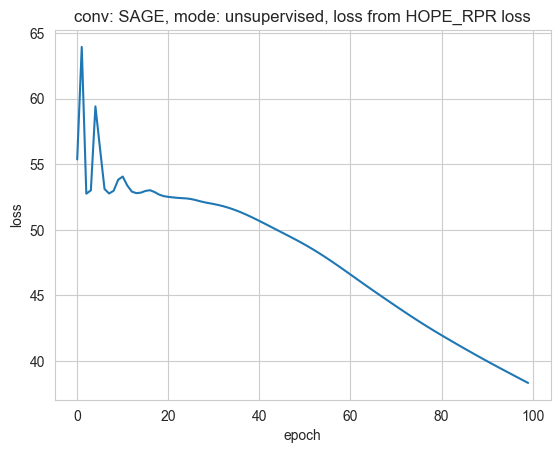

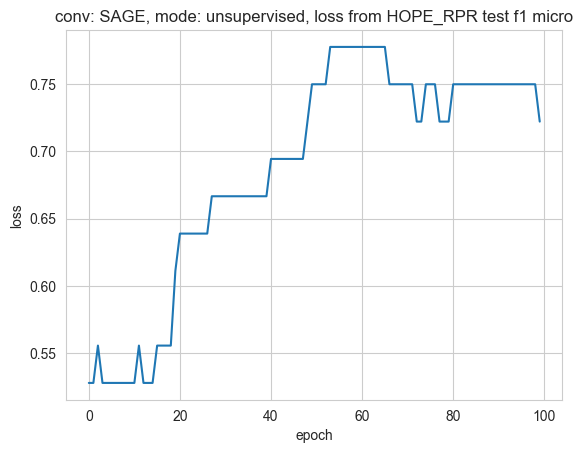

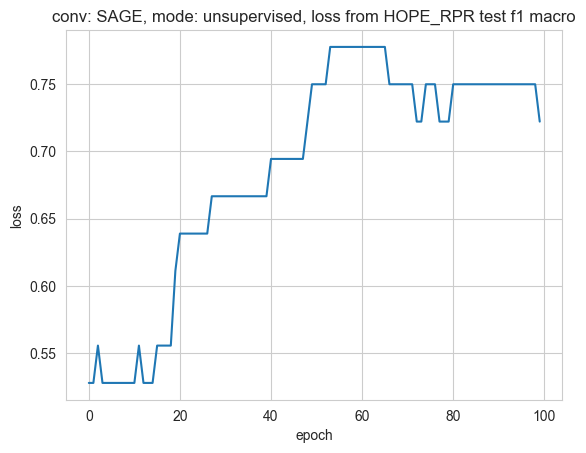

[I 2022-11-16 16:47:21,240] A new study created in memory with name: HOPE_RPR loss,SAGE conv


       loss  conv    dataset  train acc micro  test acc micro  \
0        no    no  Wisconsin         0.982955        0.900000   
1        no    no      Texas         0.992248        0.750000   
2        no    no      Texas         0.868217        0.694444   
3        no    no  Wisconsin         0.880682        0.880000   
4  HOPE_RPR  SAGE  Wisconsin         0.971591        0.920000   
5  HOPE_RPR  SAGE      Texas         0.891473        0.722222   
6  HOPE_RPR  SAGE      Texas         0.968992        0.722222   

   train acc macro  test acc macro     clf  
0         0.982955        0.900000     MLP  
1         0.992248        0.750000     MLP  
2         0.868217        0.694444  logreg  
3         0.880682        0.880000  logreg  
4         0.971591        0.920000  logreg  
5         0.891473        0.722222  logreg  
6         0.968992        0.722222     MLP  


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[I 2022-11-16 16:47:22,182] Trial 0 finished with value: 0.4 and parameters: {'hidden_layer': 128, 'out_layer': 32, 'dropout': 0.30000000000000004, 'size of network, number of convs': 1, 'lr': 0.007623423511209641, 'hidden_layer_for_classifier': 128, 'alpha': 0.8, 'lmbda': 0.5483663618759705}. Best is trial 0 with value: 0.4.
C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[I 2022-11-16 16:47:23,168] Trial 1 finished with value: 0.32 and parameters: {'hidden_layer': 32, 'out_layer': 64, 'dropout': 0.2, 'size 

conv: SAGE, mode: unsupervised, loss from HOPE_RPR
0


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 77.7837, Epoch: 000, Train acc micro: 0.5341, Test acc micro: 0.5600,Train acc macro: 0.5341, Test acc macro: 0.5600
1


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 72.3220, Epoch: 001, Train acc micro: 0.4886, Test acc micro: 0.5200,Train acc macro: 0.4886, Test acc macro: 0.5200
2


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 77.5051, Epoch: 002, Train acc micro: 0.5284, Test acc micro: 0.5600,Train acc macro: 0.5284, Test acc macro: 0.5600
3


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 73.7830, Epoch: 003, Train acc micro: 0.6136, Test acc micro: 0.7000,Train acc macro: 0.6136, Test acc macro: 0.7000
4


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 72.5053, Epoch: 004, Train acc micro: 0.6080, Test acc micro: 0.7000,Train acc macro: 0.6080, Test acc macro: 0.7000
5


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 72.5628, Epoch: 005, Train acc micro: 0.6193, Test acc micro: 0.7200,Train acc macro: 0.6193, Test acc macro: 0.7200
6


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 73.1289, Epoch: 006, Train acc micro: 0.6364, Test acc micro: 0.7200,Train acc macro: 0.6364, Test acc macro: 0.7200
7


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 73.2499, Epoch: 007, Train acc micro: 0.6534, Test acc micro: 0.7600,Train acc macro: 0.6534, Test acc macro: 0.7600
8


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 72.7176, Epoch: 008, Train acc micro: 0.6875, Test acc micro: 0.8000,Train acc macro: 0.6875, Test acc macro: 0.8000
9


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 72.2934, Epoch: 009, Train acc micro: 0.6875, Test acc micro: 0.7800,Train acc macro: 0.6875, Test acc macro: 0.7800
10


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 72.1366, Epoch: 010, Train acc micro: 0.6818, Test acc micro: 0.7800,Train acc macro: 0.6818, Test acc macro: 0.7800
11


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 72.1044, Epoch: 011, Train acc micro: 0.6932, Test acc micro: 0.7600,Train acc macro: 0.6932, Test acc macro: 0.7600
12


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 72.1266, Epoch: 012, Train acc micro: 0.6989, Test acc micro: 0.8000,Train acc macro: 0.6989, Test acc macro: 0.8000
13


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 72.1601, Epoch: 013, Train acc micro: 0.7045, Test acc micro: 0.8000,Train acc macro: 0.7045, Test acc macro: 0.8000
14


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 72.1382, Epoch: 014, Train acc micro: 0.6989, Test acc micro: 0.8000,Train acc macro: 0.6989, Test acc macro: 0.8000
15


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 72.0441, Epoch: 015, Train acc micro: 0.7045, Test acc micro: 0.8000,Train acc macro: 0.7045, Test acc macro: 0.8000
16


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 71.9265, Epoch: 016, Train acc micro: 0.7045, Test acc micro: 0.8000,Train acc macro: 0.7045, Test acc macro: 0.8000
17


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 71.8244, Epoch: 017, Train acc micro: 0.7330, Test acc micro: 0.8000,Train acc macro: 0.7330, Test acc macro: 0.8000
18


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 71.7410, Epoch: 018, Train acc micro: 0.7557, Test acc micro: 0.8200,Train acc macro: 0.7557, Test acc macro: 0.8200
19


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 71.6657, Epoch: 019, Train acc micro: 0.7614, Test acc micro: 0.8400,Train acc macro: 0.7614, Test acc macro: 0.8400
20


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 71.5906, Epoch: 020, Train acc micro: 0.7670, Test acc micro: 0.8400,Train acc macro: 0.7670, Test acc macro: 0.8400
21


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 71.5112, Epoch: 021, Train acc micro: 0.7784, Test acc micro: 0.8400,Train acc macro: 0.7784, Test acc macro: 0.8400
22


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 71.4234, Epoch: 022, Train acc micro: 0.7898, Test acc micro: 0.8600,Train acc macro: 0.7898, Test acc macro: 0.8600
23


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 71.3240, Epoch: 023, Train acc micro: 0.7898, Test acc micro: 0.8600,Train acc macro: 0.7898, Test acc macro: 0.8600
24


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 71.2148, Epoch: 024, Train acc micro: 0.8011, Test acc micro: 0.8600,Train acc macro: 0.8011, Test acc macro: 0.8600
25


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 71.1010, Epoch: 025, Train acc micro: 0.7955, Test acc micro: 0.8600,Train acc macro: 0.7955, Test acc macro: 0.8600
26


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 70.9876, Epoch: 026, Train acc micro: 0.8068, Test acc micro: 0.8600,Train acc macro: 0.8068, Test acc macro: 0.8600
27


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 70.8764, Epoch: 027, Train acc micro: 0.8239, Test acc micro: 0.8600,Train acc macro: 0.8239, Test acc macro: 0.8600
28


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 70.7671, Epoch: 028, Train acc micro: 0.8239, Test acc micro: 0.8600,Train acc macro: 0.8239, Test acc macro: 0.8600
29


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 70.6589, Epoch: 029, Train acc micro: 0.8239, Test acc micro: 0.8600,Train acc macro: 0.8239, Test acc macro: 0.8600
30


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 70.5513, Epoch: 030, Train acc micro: 0.8239, Test acc micro: 0.8600,Train acc macro: 0.8239, Test acc macro: 0.8600
31


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 70.4438, Epoch: 031, Train acc micro: 0.8239, Test acc micro: 0.8600,Train acc macro: 0.8239, Test acc macro: 0.8600
32


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 70.3350, Epoch: 032, Train acc micro: 0.8239, Test acc micro: 0.8600,Train acc macro: 0.8239, Test acc macro: 0.8600
33


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 70.2229, Epoch: 033, Train acc micro: 0.8239, Test acc micro: 0.8600,Train acc macro: 0.8239, Test acc macro: 0.8600
34


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 70.1058, Epoch: 034, Train acc micro: 0.8239, Test acc micro: 0.8600,Train acc macro: 0.8239, Test acc macro: 0.8600
35


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 69.9819, Epoch: 035, Train acc micro: 0.8295, Test acc micro: 0.8600,Train acc macro: 0.8295, Test acc macro: 0.8600
36


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 69.8503, Epoch: 036, Train acc micro: 0.8295, Test acc micro: 0.8600,Train acc macro: 0.8295, Test acc macro: 0.8600
37


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 69.7101, Epoch: 037, Train acc micro: 0.8295, Test acc micro: 0.8600,Train acc macro: 0.8295, Test acc macro: 0.8600
38


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 69.5608, Epoch: 038, Train acc micro: 0.8466, Test acc micro: 0.8800,Train acc macro: 0.8466, Test acc macro: 0.8800
39


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 69.4022, Epoch: 039, Train acc micro: 0.8523, Test acc micro: 0.8800,Train acc macro: 0.8523, Test acc macro: 0.8800
40


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 69.2342, Epoch: 040, Train acc micro: 0.8523, Test acc micro: 0.8600,Train acc macro: 0.8523, Test acc macro: 0.8600
41


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 69.0570, Epoch: 041, Train acc micro: 0.8580, Test acc micro: 0.8600,Train acc macro: 0.8580, Test acc macro: 0.8600
42


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 68.8708, Epoch: 042, Train acc micro: 0.8580, Test acc micro: 0.8600,Train acc macro: 0.8580, Test acc macro: 0.8600
43


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 68.6762, Epoch: 043, Train acc micro: 0.8580, Test acc micro: 0.8600,Train acc macro: 0.8580, Test acc macro: 0.8600
44


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 68.4735, Epoch: 044, Train acc micro: 0.8693, Test acc micro: 0.8600,Train acc macro: 0.8693, Test acc macro: 0.8600
45


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 68.2628, Epoch: 045, Train acc micro: 0.8693, Test acc micro: 0.8600,Train acc macro: 0.8693, Test acc macro: 0.8600
46


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 68.0437, Epoch: 046, Train acc micro: 0.8693, Test acc micro: 0.8600,Train acc macro: 0.8693, Test acc macro: 0.8600
47


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 67.8155, Epoch: 047, Train acc micro: 0.8807, Test acc micro: 0.8600,Train acc macro: 0.8807, Test acc macro: 0.8600
48


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 67.5774, Epoch: 048, Train acc micro: 0.8750, Test acc micro: 0.8600,Train acc macro: 0.8750, Test acc macro: 0.8600
49


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 67.3286, Epoch: 049, Train acc micro: 0.8977, Test acc micro: 0.8600,Train acc macro: 0.8977, Test acc macro: 0.8600
50


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 67.0690, Epoch: 050, Train acc micro: 0.9091, Test acc micro: 0.8600,Train acc macro: 0.9091, Test acc macro: 0.8600
51


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 66.7993, Epoch: 051, Train acc micro: 0.9148, Test acc micro: 0.8600,Train acc macro: 0.9148, Test acc macro: 0.8600
52


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 66.5204, Epoch: 052, Train acc micro: 0.9261, Test acc micro: 0.8600,Train acc macro: 0.9261, Test acc macro: 0.8600
53


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 66.2337, Epoch: 053, Train acc micro: 0.9432, Test acc micro: 0.9000,Train acc macro: 0.9432, Test acc macro: 0.9000
54


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 65.9400, Epoch: 054, Train acc micro: 0.9432, Test acc micro: 0.9000,Train acc macro: 0.9432, Test acc macro: 0.9000
55


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 65.6400, Epoch: 055, Train acc micro: 0.9489, Test acc micro: 0.9000,Train acc macro: 0.9489, Test acc macro: 0.9000
56


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 65.3341, Epoch: 056, Train acc micro: 0.9489, Test acc micro: 0.9000,Train acc macro: 0.9489, Test acc macro: 0.9000
57


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 65.0227, Epoch: 057, Train acc micro: 0.9602, Test acc micro: 0.9200,Train acc macro: 0.9602, Test acc macro: 0.9200
58


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 64.7060, Epoch: 058, Train acc micro: 0.9659, Test acc micro: 0.9200,Train acc macro: 0.9659, Test acc macro: 0.9200
59


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 64.3836, Epoch: 059, Train acc micro: 0.9716, Test acc micro: 0.9000,Train acc macro: 0.9716, Test acc macro: 0.9000
60


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 64.0551, Epoch: 060, Train acc micro: 0.9716, Test acc micro: 0.9000,Train acc macro: 0.9716, Test acc macro: 0.9000
61


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 63.7205, Epoch: 061, Train acc micro: 0.9716, Test acc micro: 0.9000,Train acc macro: 0.9716, Test acc macro: 0.9000
62


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 63.3802, Epoch: 062, Train acc micro: 0.9773, Test acc micro: 0.9000,Train acc macro: 0.9773, Test acc macro: 0.9000
63


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 63.0352, Epoch: 063, Train acc micro: 0.9773, Test acc micro: 0.9000,Train acc macro: 0.9773, Test acc macro: 0.9000
64


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 62.6868, Epoch: 064, Train acc micro: 0.9773, Test acc micro: 0.9000,Train acc macro: 0.9773, Test acc macro: 0.9000
65


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 62.3359, Epoch: 065, Train acc micro: 0.9773, Test acc micro: 0.9000,Train acc macro: 0.9773, Test acc macro: 0.9000
66


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 61.9836, Epoch: 066, Train acc micro: 0.9773, Test acc micro: 0.9000,Train acc macro: 0.9773, Test acc macro: 0.9000
67


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 61.6303, Epoch: 067, Train acc micro: 0.9773, Test acc micro: 0.9000,Train acc macro: 0.9773, Test acc macro: 0.9000
68


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 61.2763, Epoch: 068, Train acc micro: 0.9773, Test acc micro: 0.9000,Train acc macro: 0.9773, Test acc macro: 0.9000
69


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 60.9219, Epoch: 069, Train acc micro: 0.9830, Test acc micro: 0.9000,Train acc macro: 0.9830, Test acc macro: 0.9000
70


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 60.5667, Epoch: 070, Train acc micro: 0.9830, Test acc micro: 0.9000,Train acc macro: 0.9830, Test acc macro: 0.9000
71


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 60.2106, Epoch: 071, Train acc micro: 0.9830, Test acc micro: 0.9000,Train acc macro: 0.9830, Test acc macro: 0.9000
72


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 59.8530, Epoch: 072, Train acc micro: 0.9830, Test acc micro: 0.9000,Train acc macro: 0.9830, Test acc macro: 0.9000
73


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 59.4932, Epoch: 073, Train acc micro: 0.9830, Test acc micro: 0.9000,Train acc macro: 0.9830, Test acc macro: 0.9000
74


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 59.1308, Epoch: 074, Train acc micro: 0.9830, Test acc micro: 0.9000,Train acc macro: 0.9830, Test acc macro: 0.9000
75


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 58.7650, Epoch: 075, Train acc micro: 0.9830, Test acc micro: 0.9000,Train acc macro: 0.9830, Test acc macro: 0.9000
76


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 58.3954, Epoch: 076, Train acc micro: 0.9830, Test acc micro: 0.9000,Train acc macro: 0.9830, Test acc macro: 0.9000
77


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 58.0218, Epoch: 077, Train acc micro: 0.9830, Test acc micro: 0.9000,Train acc macro: 0.9830, Test acc macro: 0.9000
78


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 57.6439, Epoch: 078, Train acc micro: 0.9830, Test acc micro: 0.9000,Train acc macro: 0.9830, Test acc macro: 0.9000
79


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 57.2620, Epoch: 079, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
80


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 56.8762, Epoch: 080, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
81


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 56.4872, Epoch: 081, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
82


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 56.0956, Epoch: 082, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
83


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 55.7027, Epoch: 083, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
84


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 55.3095, Epoch: 084, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
85


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 54.9169, Epoch: 085, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
86


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 54.5261, Epoch: 086, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
87


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 54.1379, Epoch: 087, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
88


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 53.7527, Epoch: 088, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
89


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 53.3712, Epoch: 089, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
90


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.9935, Epoch: 090, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
91


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.6196, Epoch: 091, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
92


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 52.2496, Epoch: 092, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
93


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 51.8832, Epoch: 093, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
94


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 51.5204, Epoch: 094, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
95


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 51.1611, Epoch: 095, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
96


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 50.8048, Epoch: 096, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
97


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 50.4517, Epoch: 097, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
98


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Loss: 50.1013, Epoch: 098, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
99
Loss: 49.7537, Epoch: 099, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000
Loss: 49.7537, Epoch: 099, Train acc micro: 0.9886, Test acc micro: 0.9000,Train acc macro: 0.9886, Test acc macro: 0.9000


C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


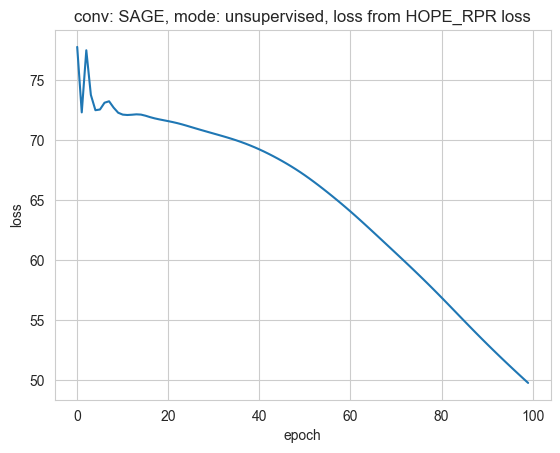

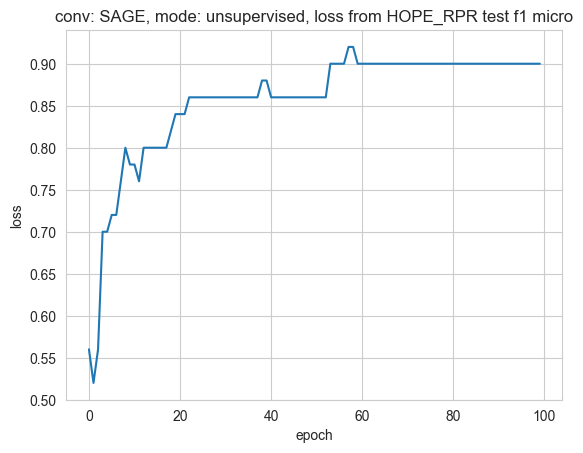

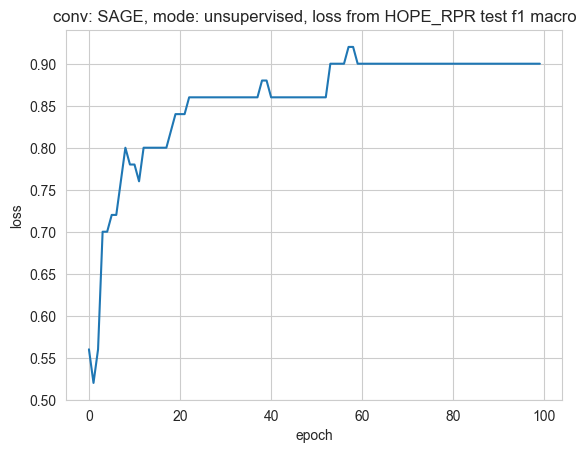

       loss  conv    dataset  train acc micro  test acc micro  \
0        no    no  Wisconsin         0.982955        0.900000   
1        no    no      Texas         0.992248        0.750000   
2        no    no      Texas         0.868217        0.694444   
3        no    no  Wisconsin         0.880682        0.880000   
4  HOPE_RPR  SAGE  Wisconsin         0.971591        0.920000   
5  HOPE_RPR  SAGE      Texas         0.891473        0.722222   
6  HOPE_RPR  SAGE      Texas         0.968992        0.722222   
7  HOPE_RPR  SAGE  Wisconsin         0.988636        0.900000   

   train acc macro  test acc macro     clf  
0         0.982955        0.900000     MLP  
1         0.992248        0.750000     MLP  
2         0.868217        0.694444  logreg  
3         0.880682        0.880000  logreg  
4         0.971591        0.920000  logreg  
5         0.891473        0.722222  logreg  
6         0.968992        0.722222     MLP  
7         0.988636        0.900000     MLP  


In [53]:
loss = HOPE_RPR
loss_name = 'HOPE_RPR'
analysis=pd.read_csv('../results/experiments_with_MLP_accuracy.csv')
analysis=analysis.drop(columns=['Unnamed: 0'])
clf='MLP'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for name in datasets_names[1:3]:
    for conv in ['SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name) & (analysis['clf'] == clf)] ) == 0:
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values = MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]

                loss_trgt["alpha"] = best_values['alpha']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma, 'MLP'],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/experiments_with_MLP_accuracy.csv')
                print(analysis)

In [61]:
analysis = pd.read_csv('../results/final_data.csv')
analysis = analysis.drop(columns=['Unnamed: 0'])
analysis = analysis[(analysis['loss'] == 'features') & (analysis['label assortativity']==0.1) & (analysis['cluster coefficient']==0.2) & (analysis['feature assortativity']==0.1) & (analysis['average shortest path']==3) & (analysis['average degree']==5)]
analysis['test acc micro']

4    0.070352
Name: test acc micro, dtype: float64

In [57]:
analysis

,loss,conv,dataset,train acc micro,test acc micro,train acc macro,test acc macro,label assortativity,feature assortativity,cluster coefficient,average shortest path,average degree,group
0,features,no,0.10.10.225,0.318117,0.090452,0.315114,0.085427,0.1,0.1,0.2,2.0,5.0,no
1,features,no,0.10.10.2220,0.783167,0.045226,0.783860,0.042904,0.1,0.1,0.2,2.0,20.0,no
2,features,no,0.10.10.2240,0.492154,0.040201,0.492240,0.039874,0.1,0.1,0.2,2.0,40.0,no
3,features,no,0.10.10.232,0.957204,0.060302,0.957408,0.067781,0.1,0.1,0.2,3.0,2.0,no
4,features,no,0.10.10.235,0.733238,0.070352,0.733541,0.069418,0.1,0.1,0.2,3.0,5.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7821,Force2Vec,GAT,0.90.90.5320,0.833096,0.276382,0.840901,0.274703,0.9,0.9,0.5,3.0,20.0,5.0
7822,Force2Vec,SAGE,0.90.90.5320,0.644793,0.115578,0.645156,0.099258,0.9,0.9,0.5,3.0,20.0,5.0
7823,Force2Vec,GCN,0.90.90.545,0.413695,0.281407,0.413026,0.277476,0.9,0.9,0.5,4.0,5.0,5.0
7824,Force2Vec,GAT,0.90.90.545,0.633381,0.291457,0.633967,0.271363,0.9,0.9,0.5,4.0,5.0,5.0


[I 2022-11-14 14:58:17,953] A new study created in memory with name: LINE loss,GCN conv
[I 2022-11-14 14:58:24,805] Trial 0 finished with value: 0.2380619024282447 and parameters: {'hidden_layer': 256, 'out_layer': 32, 'dropout': 0.4, 'size of network, number of convs': 2, 'lr': 0.0054822792212987645, 'reg_lambda': 0.01, 'n_estimators': 250, 'max_depth': 7, 'num_negative_samples': 11, 'lmbda': 0.40547634715723746}. Best is trial 0 with value: 0.2380619024282447.
[I 2022-11-14 14:58:31,415] Trial 1 finished with value: 0.25371731211689774 and parameters: {'hidden_layer': 256, 'out_layer': 32, 'dropout': 0.5, 'size of network, number of convs': 2, 'lr': 0.0057534293104274945, 'reg_lambda': 10, 'n_estimators': 500, 'max_depth': 7, 'num_negative_samples': 11, 'lmbda': 0.05032029497001922}. Best is trial 1 with value: 0.25371731211689774.
[I 2022-11-14 14:58:32,266] Trial 2 finished with value: 0.0 and parameters: {'hidden_layer': 256, 'out_layer': 128, 'dropout': 0.0, 'size of network, num

conv: GCN, mode: unsupervised, loss from LINE
0
Loss: 351.6750, Epoch: 000, Train acc micro: 0.9030, Test acc micro: 0.2714,Train acc macro: 0.9030, Test acc macro: 0.2651
1
Loss: 184.9060, Epoch: 001, Train acc micro: 0.4964, Test acc micro: 0.1558,Train acc macro: 0.4921, Test acc macro: 0.1483
2
Loss: 109.0102, Epoch: 002, Train acc micro: 0.9843, Test acc micro: 0.2161,Train acc macro: 0.9843, Test acc macro: 0.2102
3
Loss: 66.5590, Epoch: 003, Train acc micro: 0.9929, Test acc micro: 0.2362,Train acc macro: 0.9929, Test acc macro: 0.2338
4
Loss: 42.5508, Epoch: 004, Train acc micro: 0.9971, Test acc micro: 0.2312,Train acc macro: 0.9971, Test acc macro: 0.2222
5
Loss: 29.1602, Epoch: 005, Train acc micro: 0.9986, Test acc micro: 0.2111,Train acc macro: 0.9986, Test acc macro: 0.2085
6
Loss: 20.5121, Epoch: 006, Train acc micro: 0.9829, Test acc micro: 0.1859,Train acc macro: 0.9829, Test acc macro: 0.1761
7
Loss: 15.4362, Epoch: 007, Train acc micro: 0.9486, Test acc micro: 0.2161

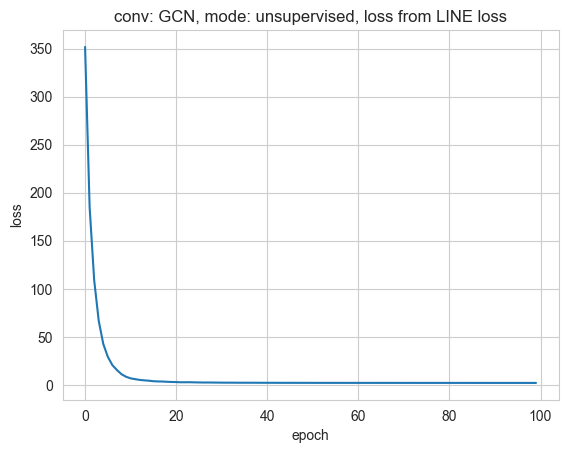

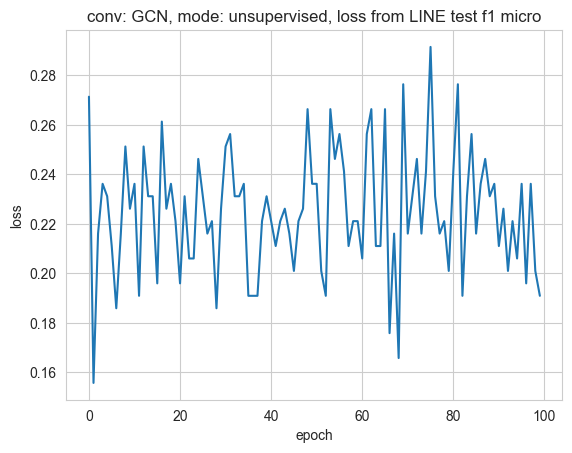

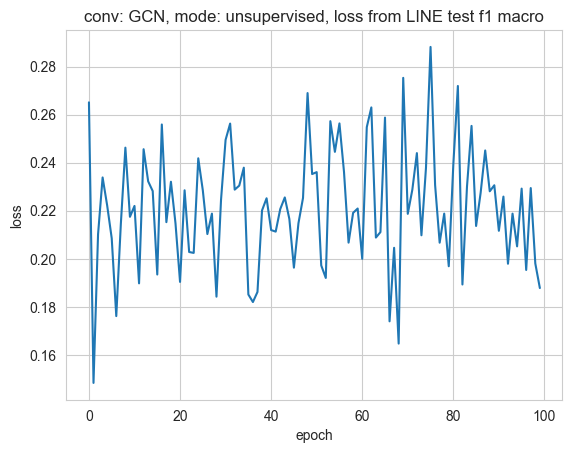

In [28]:
loss = LINE
loss_name = 'LINE'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')
analysis = analysis.drop(columns=['Unnamed: 0'])
conv = 'GCN'
for (l,f,cl,asp,ad) in datasets_names:
    name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
    if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]

                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


In [12]:
datasets_names=[(0.9, 0.5, 0.01, 2, 5)]

In [29]:
datasets_names

[(0.5, 0.1, 0.2, 4, 2)]

[I 2022-11-14 15:49:10,700] A new study created in memory with name: LaplacianEigenMaps loss,GCN conv
[I 2022-11-14 15:49:13,920] Trial 0 finished with value: 0.19385240410878216 and parameters: {'hidden_layer': 128, 'out_layer': 128, 'dropout': 0.5, 'size of network, number of convs': 1, 'lr': 0.007777127193822188, 'reg_lambda': 0.4, 'n_estimators': 5, 'max_depth': 1, 'lmbda': 0.9607922690701756}. Best is trial 0 with value: 0.19385240410878216.
[I 2022-11-14 15:49:15,871] Trial 1 finished with value: 0.2446456517625932 and parameters: {'hidden_layer': 128, 'out_layer': 64, 'dropout': 0.1, 'size of network, number of convs': 2, 'lr': 0.00791783965440426, 'reg_lambda': 100, 'n_estimators': 5, 'max_depth': 9, 'lmbda': 0.9980112113131758}. Best is trial 1 with value: 0.2446456517625932.
[I 2022-11-14 15:49:17,949] Trial 2 finished with value: 0.1779936685158942 and parameters: {'hidden_layer': 32, 'out_layer': 64, 'dropout': 0.5, 'size of network, number of convs': 2, 'lr': 0.00970269343

conv: GCN, mode: unsupervised, loss from LaplacianEigenMaps
0
Loss: 3889.2080, Epoch: 000, Train acc micro: 0.9986, Test acc micro: 0.2312,Train acc macro: 0.9986, Test acc macro: 0.2302
1
Loss: 2811.6147, Epoch: 001, Train acc micro: 0.8773, Test acc micro: 0.1960,Train acc macro: 0.8771, Test acc macro: 0.1963
2
Loss: 2084.5256, Epoch: 002, Train acc micro: 0.8017, Test acc micro: 0.2161,Train acc macro: 0.8017, Test acc macro: 0.2172
3
Loss: 1604.3389, Epoch: 003, Train acc micro: 1.0000, Test acc micro: 0.2312,Train acc macro: 1.0000, Test acc macro: 0.2312
4
Loss: 1291.1241, Epoch: 004, Train acc micro: 0.6705, Test acc micro: 0.2412,Train acc macro: 0.6709, Test acc macro: 0.2373
5
Loss: 1088.2509, Epoch: 005, Train acc micro: 0.9529, Test acc micro: 0.2010,Train acc macro: 0.9529, Test acc macro: 0.1970
6
Loss: 957.6191, Epoch: 006, Train acc micro: 0.9843, Test acc micro: 0.2663,Train acc macro: 0.9843, Test acc macro: 0.2611
7
Loss: 871.9427, Epoch: 007, Train acc micro: 0.724

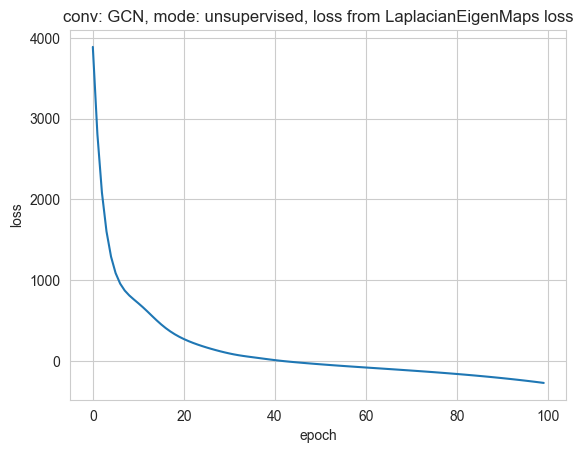

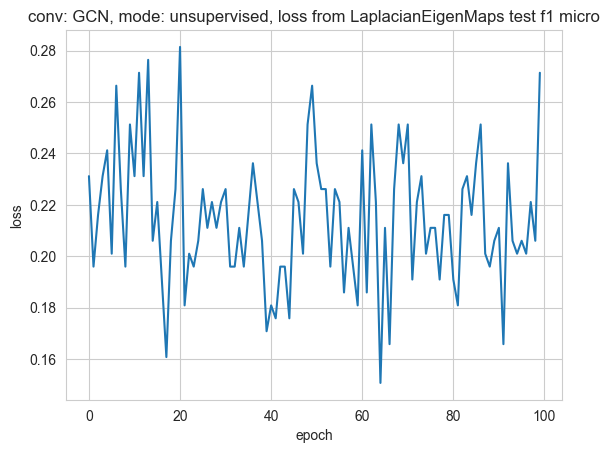

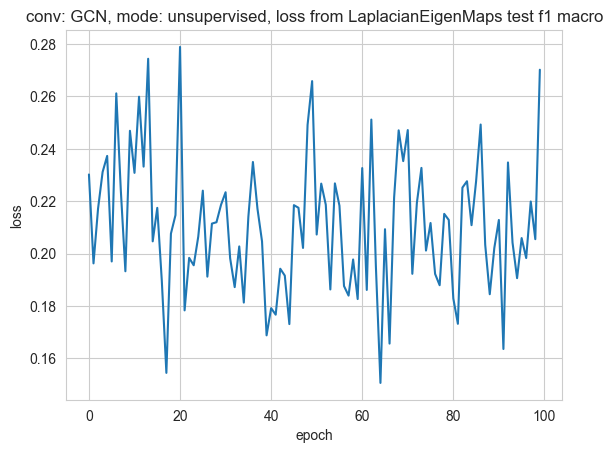

In [30]:
loss = LapEigen
loss_name = 'LapEigen'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')
analysis = analysis.drop(columns=['Unnamed: 0'])
conv = 'GCN'
for (l,f,cl,asp,ad) in datasets_names:
    name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
    if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["lmbda"] = best_values['lmbda']


                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


[I 2022-11-14 17:11:56,141] A new study created in memory with name: HOPE_CommonNeighbors loss,GCN conv
[I 2022-11-14 17:11:58,813] Trial 0 finished with value: 0.1888492410063381 and parameters: {'hidden_layer': 32, 'out_layer': 128, 'dropout': 0.0, 'size of network, number of convs': 2, 'lr': 0.006959129564246061, 'reg_lambda': 30, 'n_estimators': 5, 'max_depth': 9, 'lmbda': 0.1911165203963272}. Best is trial 0 with value: 0.1888492410063381.
[I 2022-11-14 17:12:13,927] Trial 1 finished with value: 0.26064390882760224 and parameters: {'hidden_layer': 128, 'out_layer': 64, 'dropout': 0.0, 'size of network, number of convs': 1, 'lr': 0.00661145048905386, 'reg_lambda': 0.001, 'n_estimators': 500, 'max_depth': 9, 'lmbda': 0.61765230035485}. Best is trial 1 with value: 0.26064390882760224.
[I 2022-11-14 17:12:17,247] Trial 2 finished with value: 0.22816851803140747 and parameters: {'hidden_layer': 128, 'out_layer': 64, 'dropout': 0.1, 'size of network, number of convs': 3, 'lr': 0.0066869

conv: GCN, mode: unsupervised, loss from HOPE_CommonNeighbors
0
Loss: 273953792.0000, Epoch: 000, Train acc micro: 0.9943, Test acc micro: 0.2864,Train acc macro: 0.9943, Test acc macro: 0.2851
1
Loss: 109783032.0000, Epoch: 001, Train acc micro: 0.9986, Test acc micro: 0.2312,Train acc macro: 0.9986, Test acc macro: 0.2299
2
Loss: 70899864.0000, Epoch: 002, Train acc micro: 0.9971, Test acc micro: 0.2563,Train acc macro: 0.9971, Test acc macro: 0.2582
3
Loss: 57940492.0000, Epoch: 003, Train acc micro: 0.9829, Test acc micro: 0.1809,Train acc macro: 0.9829, Test acc macro: 0.1808
4
Loss: 53736840.0000, Epoch: 004, Train acc micro: 0.9715, Test acc micro: 0.2412,Train acc macro: 0.9714, Test acc macro: 0.2380
5
Loss: 51871388.0000, Epoch: 005, Train acc micro: 1.0000, Test acc micro: 0.2412,Train acc macro: 1.0000, Test acc macro: 0.2379
6
Loss: 49540684.0000, Epoch: 006, Train acc micro: 0.9757, Test acc micro: 0.2211,Train acc macro: 0.9757, Test acc macro: 0.2174
7
Loss: 46153624.00

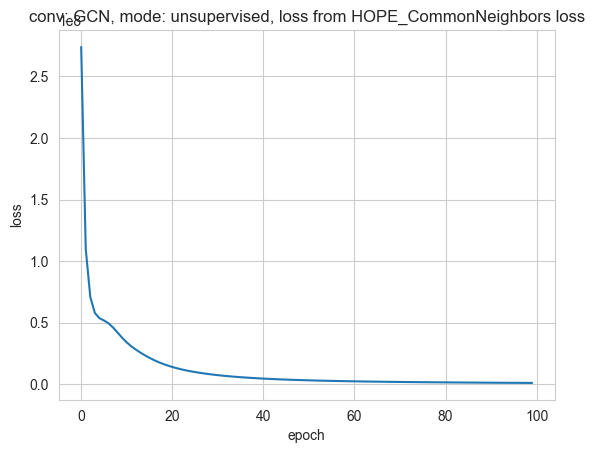

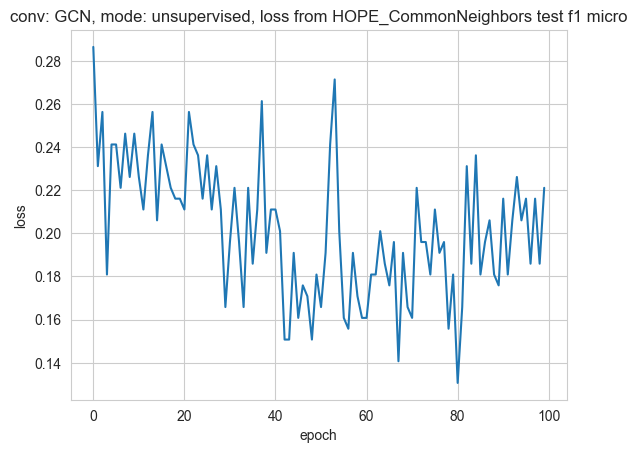

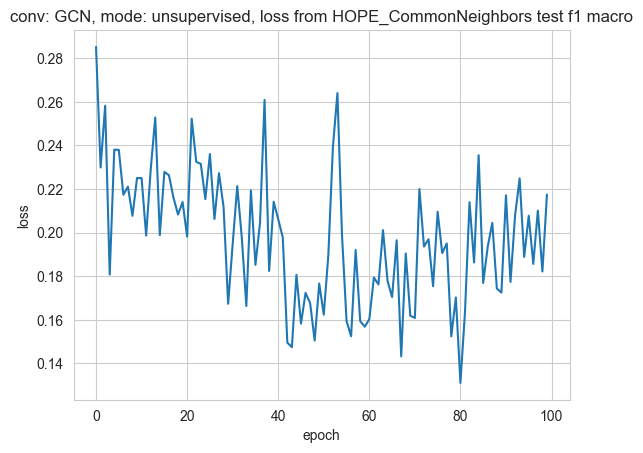

In [31]:
loss = HOPE_CN
loss_name = 'HOPE_CN'
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')
analysis=analysis.drop(columns=['Unnamed: 0'])
conv = 'GCN'
for (l,f,cl,asp,ad) in datasets_names:
    name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
    if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


In [9]:
loss = Node2Vec
loss_name = 'Node2Vec'
device= 'cpu'
analysis = pd.read_csv('../results/classification_catboost.csv')
analysis = analysis.drop(columns=['Unnamed: 0'])

for name in ['Cornell']:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["walks_per_node"] = best_values['walk_length']
                loss_trgt["walk_length"] = best_values['walk_length']
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["context_size"] = best_values['context_size']
                loss_trgt["p"] = best_values['p']
                loss_trgt["q"] = best_values['q']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


[I 2022-11-09 13:33:24,410] A new study created in memory with name: Node2Vec loss,GCN conv
[W 2022-11-09 13:33:24,426] Trial 0 failed because of the following error: TypeError("'NoneType' object is not callable")
Traceback (most recent call last):
  File "C:\Users\User\Desktop\Benchmarking-Loss-Functions\venv\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_1420\2232532568.py", line 48, in objective
    loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch,loss_to_train)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_1420\1223343394.py", line 56, in train
    samples = self.sampling(Sampler,epoch, indices_of_train_data,loss)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_1420\1223343394.py", line 41, in sampling
    self.samples = Sampler.sample(nodes)
  File "C:\Users\User\Desktop\Benchmarking-Loss-Functions\modules\sampling.py", line 84, in s

TypeError: 'NoneType' object is not callable

[I 2022-11-09 13:33:33,835] A new study created in memory with name: VERSE_PPR loss,GCN conv


1
2
3
4


[I 2022-11-09 13:33:38,054] Trial 0 finished with value: 0.34455272098781475 and parameters: {'hidden_layer': 64, 'out_layer': 64, 'dropout': 0.0, 'size of network, number of convs': 1, 'lr': 0.007864763188679938, 'num_negative_samples': 1, 'alpha': 0.5, 'lmbda': 0.6846051283705041}. Best is trial 0 with value: 0.34455272098781475.


1
2
3
4


[I 2022-11-09 13:33:40,382] Trial 1 finished with value: 0.5937950762616616 and parameters: {'hidden_layer': 128, 'out_layer': 128, 'dropout': 0.30000000000000004, 'size of network, number of convs': 1, 'lr': 0.008292555042793134, 'num_negative_samples': 1, 'alpha': 0.4, 'lmbda': 0.24370564174009957}. Best is trial 1 with value: 0.5937950762616616.
[I 2022-11-09 13:33:41,694] Trial 2 finished with value: 0.43744488188954506 and parameters: {'hidden_layer': 32, 'out_layer': 32, 'dropout': 0.0, 'size of network, number of convs': 1, 'lr': 0.00838311001505726, 'num_negative_samples': 6, 'alpha': 0.7, 'lmbda': 0.8825197474187313}. Best is trial 1 with value: 0.5937950762616616.


1
2
3
4


[I 2022-11-09 13:33:43,288] Trial 3 finished with value: 0.5060742150229659 and parameters: {'hidden_layer': 32, 'out_layer': 32, 'dropout': 0.1, 'size of network, number of convs': 1, 'lr': 0.008503600728225862, 'num_negative_samples': 11, 'alpha': 0.6, 'lmbda': 0.7378805460311791}. Best is trial 1 with value: 0.5937950762616616.
[I 2022-11-09 13:33:44,554] Trial 4 finished with value: 0.2086996778999804 and parameters: {'hidden_layer': 32, 'out_layer': 128, 'dropout': 0.0, 'size of network, number of convs': 2, 'lr': 0.007423543266483855, 'num_negative_samples': 6, 'alpha': 0.7, 'lmbda': 0.29435392308483377}. Best is trial 1 with value: 0.5937950762616616.
[I 2022-11-09 13:33:45,085] Trial 5 finished with value: 0.0 and parameters: {'hidden_layer': 256, 'out_layer': 64, 'dropout': 0.1, 'size of network, number of convs': 2, 'lr': 0.007414262947416338, 'num_negative_samples': 16, 'alpha': 0.7, 'lmbda': 0.27469109483896226}. Best is trial 1 with value: 0.5937950762616616.
[I 2022-11-09

1
2
3
4


[I 2022-11-09 13:33:48,648] Trial 8 finished with value: 0.4991871235073112 and parameters: {'hidden_layer': 256, 'out_layer': 64, 'dropout': 0.5, 'size of network, number of convs': 1, 'lr': 0.005584313824556686, 'num_negative_samples': 6, 'alpha': 0.2, 'lmbda': 0.8776363274652687}. Best is trial 6 with value: 0.6362023392900426.
[I 2022-11-09 13:33:49,913] Trial 9 finished with value: 0.2086996778999804 and parameters: {'hidden_layer': 256, 'out_layer': 32, 'dropout': 0.5, 'size of network, number of convs': 2, 'lr': 0.005130636464931892, 'num_negative_samples': 11, 'alpha': 0.6, 'lmbda': 0.9354831615368193}. Best is trial 6 with value: 0.6362023392900426.
[I 2022-11-09 13:33:50,554] Trial 10 finished with value: 0.0 and parameters: {'hidden_layer': 128, 'out_layer': 128, 'dropout': 0.30000000000000004, 'size of network, number of convs': 3, 'lr': 0.009867352870014773, 'num_negative_samples': 21, 'alpha': 0.1, 'lmbda': 0.5530993271178664}. Best is trial 6 with value: 0.63620233929004

1
2
3
4


[I 2022-11-09 13:33:52,976] Trial 12 finished with value: 0.0 and parameters: {'hidden_layer': 128, 'out_layer': 128, 'dropout': 0.4, 'size of network, number of convs': 3, 'lr': 0.006536298307563684, 'num_negative_samples': 21, 'alpha': 0.3, 'lmbda': 0.3177809379810911}. Best is trial 6 with value: 0.6362023392900426.
[I 2022-11-09 13:33:54,398] Trial 13 finished with value: 0.47919685895217384 and parameters: {'hidden_layer': 128, 'out_layer': 128, 'dropout': 0.2, 'size of network, number of convs': 1, 'lr': 0.009190621455411673, 'num_negative_samples': 21, 'alpha': 0.4, 'lmbda': 0.08697705746559947}. Best is trial 6 with value: 0.6362023392900426.


1
2
3
4


[I 2022-11-09 13:33:56,116] Trial 14 finished with value: 0.4361601658057396 and parameters: {'hidden_layer': 128, 'out_layer': 128, 'dropout': 0.4, 'size of network, number of convs': 1, 'lr': 0.006651525776019276, 'num_negative_samples': 1, 'alpha': 0.9, 'lmbda': 0.4720000839644628}. Best is trial 6 with value: 0.6362023392900426.


1
2
3
4


[I 2022-11-09 13:33:57,866] Trial 15 finished with value: 0.3913539251583432 and parameters: {'hidden_layer': 64, 'out_layer': 128, 'dropout': 0.4, 'size of network, number of convs': 1, 'lr': 0.0090799737152562, 'num_negative_samples': 16, 'alpha': 0.8, 'lmbda': 0.4620566180597056}. Best is trial 6 with value: 0.6362023392900426.
[I 2022-11-09 13:33:58,507] Trial 16 finished with value: 0.0 and parameters: {'hidden_layer': 128, 'out_layer': 128, 'dropout': 0.2, 'size of network, number of convs': 3, 'lr': 0.006813361935546516, 'num_negative_samples': 1, 'alpha': 0.4, 'lmbda': 0.1742999584848134}. Best is trial 6 with value: 0.6362023392900426.
[I 2022-11-09 13:33:59,898] Trial 17 finished with value: 0.5868938953886336 and parameters: {'hidden_layer': 128, 'out_layer': 128, 'dropout': 0.4, 'size of network, number of convs': 1, 'lr': 0.008052513935058816, 'num_negative_samples': 21, 'alpha': 0.8, 'lmbda': 0.5956565619183319}. Best is trial 6 with value: 0.6362023392900426.
[I 2022-11-

conv: GCN, mode: unsupervised, loss from VERSE_PPR
0
Loss: 0.7476, Epoch: 000, Train acc micro: 1.0000, Test acc micro: 0.6111,Train acc macro: 1.0000, Test acc macro: 0.2817
1
Loss: 0.7623, Epoch: 001, Train acc micro: 1.0000, Test acc micro: 0.5556,Train acc macro: 1.0000, Test acc macro: 0.2157
2
Loss: 0.7480, Epoch: 002, Train acc micro: 1.0000, Test acc micro: 0.6389,Train acc macro: 1.0000, Test acc macro: 0.3357
3
Loss: 0.7508, Epoch: 003, Train acc micro: 1.0000, Test acc micro: 0.6111,Train acc macro: 1.0000, Test acc macro: 0.2741
4
Loss: 0.7556, Epoch: 004, Train acc micro: 1.0000, Test acc micro: 0.6389,Train acc macro: 1.0000, Test acc macro: 0.2756
5
Loss: 0.7521, Epoch: 005, Train acc micro: 1.0000, Test acc micro: 0.6389,Train acc macro: 1.0000, Test acc macro: 0.3151
6
Loss: 0.7477, Epoch: 006, Train acc micro: 1.0000, Test acc micro: 0.5556,Train acc macro: 1.0000, Test acc macro: 0.1995
7
Loss: 0.7476, Epoch: 007, Train acc micro: 1.0000, Test acc micro: 0.5278,Train

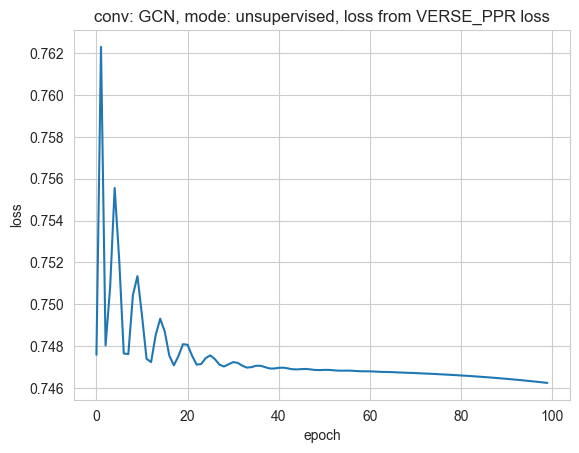

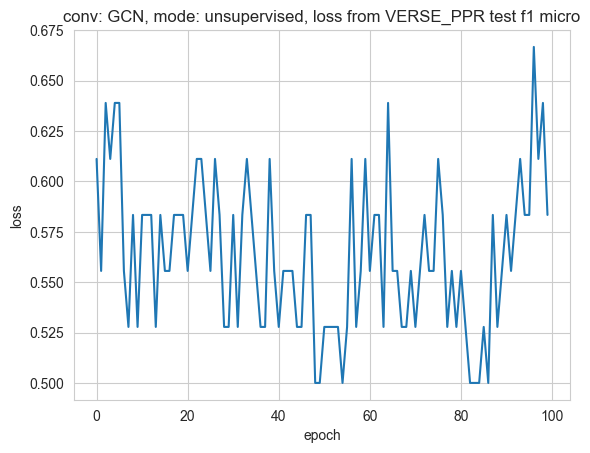

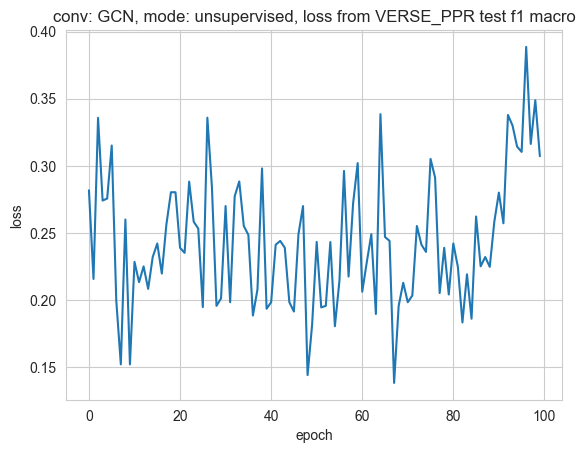

[I 2022-11-09 13:46:45,802] A new study created in memory with name: VERSE_PPR loss,GCN conv


1
2
3
4


[I 2022-11-09 13:46:46,853] Trial 0 finished with value: 0.0 and parameters: {'hidden_layer': 32, 'out_layer': 32, 'dropout': 0.30000000000000004, 'size of network, number of convs': 2, 'lr': 0.00564101295491182, 'num_negative_samples': 1, 'alpha': 0.4, 'lmbda': 0.1368131298328581}. Best is trial 0 with value: 0.0.


1
2
3
4


[I 2022-11-09 13:46:47,763] Trial 1 finished with value: 0.0 and parameters: {'hidden_layer': 32, 'out_layer': 128, 'dropout': 0.1, 'size of network, number of convs': 2, 'lr': 0.007804629749084796, 'num_negative_samples': 11, 'alpha': 0.1, 'lmbda': 0.05177305933306242}. Best is trial 0 with value: 0.0.


1
2
3
4


[I 2022-11-09 13:46:49,452] Trial 2 finished with value: 0.4226493565977341 and parameters: {'hidden_layer': 128, 'out_layer': 64, 'dropout': 0.2, 'size of network, number of convs': 2, 'lr': 0.009445576325985881, 'num_negative_samples': 6, 'alpha': 0.2, 'lmbda': 0.008036278563008148}. Best is trial 2 with value: 0.4226493565977341.


1
2
3
4


[I 2022-11-09 13:46:50,451] Trial 3 finished with value: 0.0 and parameters: {'hidden_layer': 64, 'out_layer': 128, 'dropout': 0.2, 'size of network, number of convs': 3, 'lr': 0.005029582389527643, 'num_negative_samples': 11, 'alpha': 0.7, 'lmbda': 0.8121285853388114}. Best is trial 2 with value: 0.4226493565977341.
[I 2022-11-09 13:46:51,098] Trial 4 finished with value: 0.0 and parameters: {'hidden_layer': 256, 'out_layer': 32, 'dropout': 0.5, 'size of network, number of convs': 3, 'lr': 0.006390956341751774, 'num_negative_samples': 6, 'alpha': 0.7, 'lmbda': 0.10228594026314974}. Best is trial 2 with value: 0.4226493565977341.


1
2
3
4


[I 2022-11-09 13:46:52,701] Trial 5 finished with value: 0.4499657051403686 and parameters: {'hidden_layer': 256, 'out_layer': 32, 'dropout': 0.0, 'size of network, number of convs': 1, 'lr': 0.005634166060996228, 'num_negative_samples': 1, 'alpha': 0.5, 'lmbda': 0.006583535498717263}. Best is trial 5 with value: 0.4499657051403686.


1
2
3
4


[I 2022-11-09 13:46:53,673] Trial 6 finished with value: 0.0 and parameters: {'hidden_layer': 32, 'out_layer': 128, 'dropout': 0.0, 'size of network, number of convs': 3, 'lr': 0.0076354617976102, 'num_negative_samples': 6, 'alpha': 0.6, 'lmbda': 0.4496832524735993}. Best is trial 5 with value: 0.4499657051403686.


1
2
3
4


[I 2022-11-09 13:46:54,662] Trial 7 finished with value: 0.0 and parameters: {'hidden_layer': 128, 'out_layer': 32, 'dropout': 0.4, 'size of network, number of convs': 3, 'lr': 0.007071321919110311, 'num_negative_samples': 21, 'alpha': 0.8, 'lmbda': 0.9567919982793704}. Best is trial 5 with value: 0.4499657051403686.
[I 2022-11-09 13:46:55,917] Trial 8 finished with value: 0.5114083119567587 and parameters: {'hidden_layer': 256, 'out_layer': 32, 'dropout': 0.1, 'size of network, number of convs': 1, 'lr': 0.008392060957332092, 'num_negative_samples': 11, 'alpha': 0.8, 'lmbda': 0.209797672895367}. Best is trial 8 with value: 0.5114083119567587.
[I 2022-11-09 13:46:57,342] Trial 9 finished with value: 0.5399664674850008 and parameters: {'hidden_layer': 256, 'out_layer': 32, 'dropout': 0.0, 'size of network, number of convs': 3, 'lr': 0.008711104766641699, 'num_negative_samples': 6, 'alpha': 0.4, 'lmbda': 0.23177802630514832}. Best is trial 9 with value: 0.5399664674850008.
[I 2022-11-09 

1
2
3
4


[I 2022-11-09 13:47:00,872] Trial 12 finished with value: 0.3878955567713595 and parameters: {'hidden_layer': 256, 'out_layer': 32, 'dropout': 0.1, 'size of network, number of convs': 1, 'lr': 0.008691016958778693, 'num_negative_samples': 21, 'alpha': 0.9, 'lmbda': 0.2750992754332604}. Best is trial 9 with value: 0.5399664674850008.
[I 2022-11-09 13:47:02,176] Trial 13 finished with value: 0.49199948380409103 and parameters: {'hidden_layer': 256, 'out_layer': 32, 'dropout': 0.0, 'size of network, number of convs': 1, 'lr': 0.008601196048651002, 'num_negative_samples': 16, 'alpha': 0.4, 'lmbda': 0.6265744410935374}. Best is trial 9 with value: 0.5399664674850008.


1
2
3
4


[I 2022-11-09 13:47:03,834] Trial 14 finished with value: 0.45573271518764996 and parameters: {'hidden_layer': 256, 'out_layer': 32, 'dropout': 0.1, 'size of network, number of convs': 1, 'lr': 0.009248349503924575, 'num_negative_samples': 11, 'alpha': 0.3, 'lmbda': 0.2532842337530365}. Best is trial 9 with value: 0.5399664674850008.
[I 2022-11-09 13:47:05,118] Trial 15 finished with value: 0.4629100498862757 and parameters: {'hidden_layer': 256, 'out_layer': 64, 'dropout': 0.0, 'size of network, number of convs': 1, 'lr': 0.008101392907197205, 'num_negative_samples': 6, 'alpha': 0.8, 'lmbda': 0.5830417722297454}. Best is trial 9 with value: 0.5399664674850008.
[I 2022-11-09 13:47:05,811] Trial 16 finished with value: 0.0 and parameters: {'hidden_layer': 256, 'out_layer': 32, 'dropout': 0.2, 'size of network, number of convs': 3, 'lr': 0.007011435725602027, 'num_negative_samples': 11, 'alpha': 0.1, 'lmbda': 0.3602173220786785}. Best is trial 9 with value: 0.5399664674850008.
[I 2022-11

conv: GCN, mode: unsupervised, loss from VERSE_PPR
0
Loss: 0.7611, Epoch: 000, Train acc micro: 1.0000, Test acc micro: 0.5833,Train acc macro: 1.0000, Test acc macro: 0.3113
1
Loss: 0.7764, Epoch: 001, Train acc micro: 0.9845, Test acc micro: 0.6111,Train acc macro: 0.9790, Test acc macro: 0.4083
2
Loss: 0.7615, Epoch: 002, Train acc micro: 1.0000, Test acc micro: 0.6389,Train acc macro: 1.0000, Test acc macro: 0.4399
3
Loss: 0.7640, Epoch: 003, Train acc micro: 1.0000, Test acc micro: 0.6111,Train acc macro: 1.0000, Test acc macro: 0.3986
4
Loss: 0.7693, Epoch: 004, Train acc micro: 0.9845, Test acc micro: 0.6389,Train acc macro: 0.9790, Test acc macro: 0.4697
5
Loss: 0.7659, Epoch: 005, Train acc micro: 1.0000, Test acc micro: 0.5833,Train acc macro: 1.0000, Test acc macro: 0.4055
6
Loss: 0.7611, Epoch: 006, Train acc micro: 1.0000, Test acc micro: 0.5278,Train acc macro: 1.0000, Test acc macro: 0.2882
7
Loss: 0.7609, Epoch: 007, Train acc micro: 0.9845, Test acc micro: 0.6667,Train

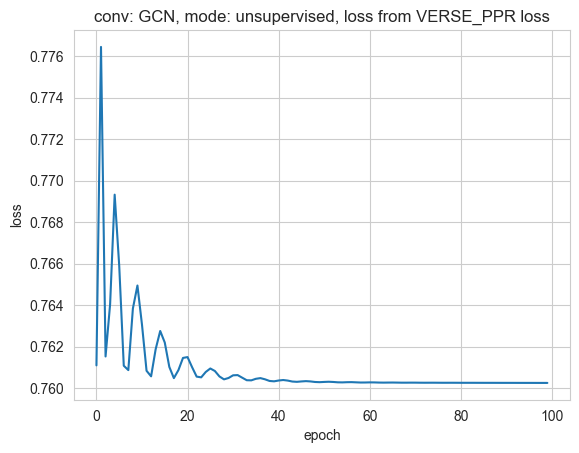

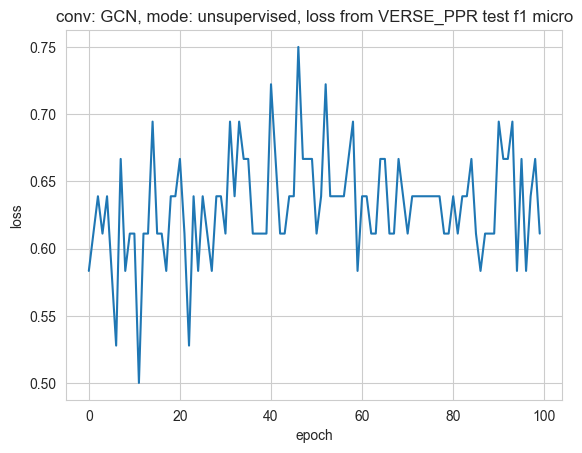

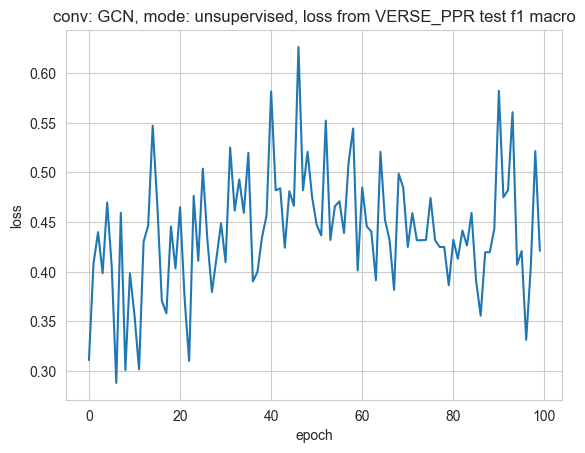

In [10]:
loss = VERSE_PPR
loss_name = 'VERSE_PPR'

device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')
analysis = analysis.drop(columns=['Unnamed: 0'])
for name in datasets_names[:2]:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["alpha"] = best_values['alpha']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


[I 2022-11-09 14:39:50,547] A new study created in memory with name: VERSE_Adj loss,GCN conv
[I 2022-11-09 14:39:53,722] Trial 0 finished with value: 0.30281331944409007 and parameters: {'hidden_layer': 64, 'out_layer': 128, 'dropout': 0.0, 'size of network, number of convs': 1, 'lr': 0.008982276210820553, 'num_negative_samples': 11, 'lmbda': 0.565553085572354}. Best is trial 0 with value: 0.30281331944409007.
[I 2022-11-09 14:39:55,390] Trial 1 finished with value: 0.3083315267085868 and parameters: {'hidden_layer': 256, 'out_layer': 128, 'dropout': 0.2, 'size of network, number of convs': 1, 'lr': 0.008817898892478766, 'num_negative_samples': 6, 'lmbda': 0.45384609898567596}. Best is trial 1 with value: 0.3083315267085868.
[I 2022-11-09 14:39:56,051] Trial 2 finished with value: 0.0 and parameters: {'hidden_layer': 32, 'out_layer': 32, 'dropout': 0.2, 'size of network, number of convs': 3, 'lr': 0.008064633051462688, 'num_negative_samples': 6, 'lmbda': 0.2812351697501775}. Best is tr

conv: GCN, mode: unsupervised, loss from VERSE_Adj
0
Loss: 1.1100, Epoch: 000, Train acc micro: 1.0000, Test acc micro: 0.6667,Train acc macro: 1.0000, Test acc macro: 0.3311
1
Loss: 1.1180, Epoch: 001, Train acc micro: 1.0000, Test acc micro: 0.5278,Train acc macro: 1.0000, Test acc macro: 0.2136
2
Loss: 1.1099, Epoch: 002, Train acc micro: 1.0000, Test acc micro: 0.5833,Train acc macro: 1.0000, Test acc macro: 0.2268
3
Loss: 1.1114, Epoch: 003, Train acc micro: 1.0000, Test acc micro: 0.5556,Train acc macro: 1.0000, Test acc macro: 0.2697
4
Loss: 1.1139, Epoch: 004, Train acc micro: 1.0000, Test acc micro: 0.6111,Train acc macro: 1.0000, Test acc macro: 0.3228
5
Loss: 1.1118, Epoch: 005, Train acc micro: 1.0000, Test acc micro: 0.5556,Train acc macro: 1.0000, Test acc macro: 0.2826
6
Loss: 1.1093, Epoch: 006, Train acc micro: 1.0000, Test acc micro: 0.4167,Train acc macro: 1.0000, Test acc macro: 0.1699
7
Loss: 1.1095, Epoch: 007, Train acc micro: 1.0000, Test acc micro: 0.4444,Train

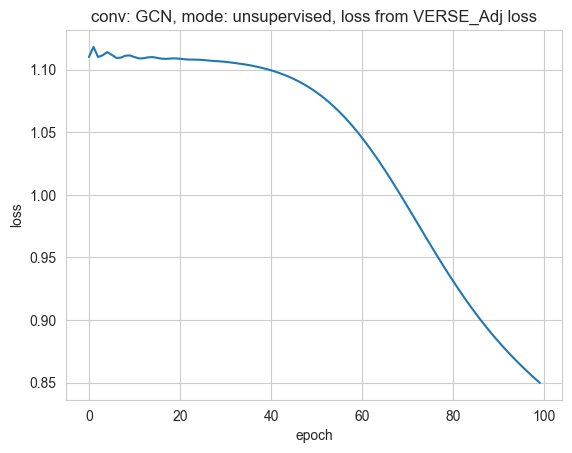

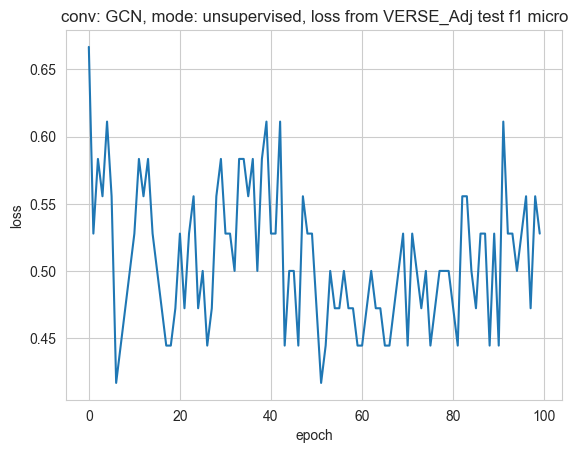

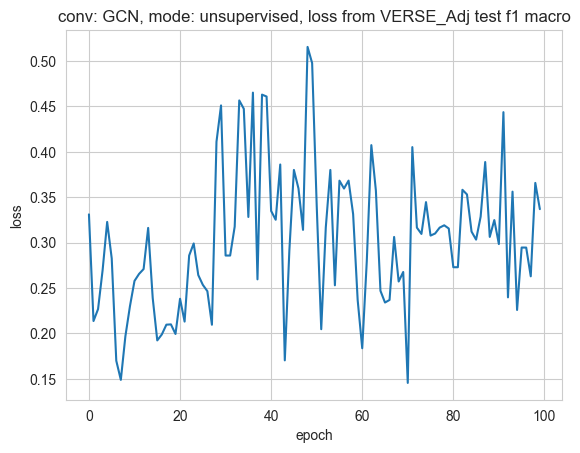

[I 2022-11-09 14:52:39,295] A new study created in memory with name: VERSE_Adj loss,GCN conv
[I 2022-11-09 14:52:40,281] Trial 0 finished with value: 0.0 and parameters: {'hidden_layer': 64, 'out_layer': 32, 'dropout': 0.0, 'size of network, number of convs': 2, 'lr': 0.008444624308806515, 'num_negative_samples': 11, 'lmbda': 0.3633455085004771}. Best is trial 0 with value: 0.0.
[I 2022-11-09 14:52:41,560] Trial 1 finished with value: 0.3404414533245951 and parameters: {'hidden_layer': 128, 'out_layer': 32, 'dropout': 0.2, 'size of network, number of convs': 1, 'lr': 0.007643110595521042, 'num_negative_samples': 11, 'lmbda': 0.7752498210671216}. Best is trial 1 with value: 0.3404414533245951.
[I 2022-11-09 14:52:42,836] Trial 2 finished with value: 0.3404414533245951 and parameters: {'hidden_layer': 32, 'out_layer': 32, 'dropout': 0.30000000000000004, 'size of network, number of convs': 1, 'lr': 0.00557609502916944, 'num_negative_samples': 16, 'lmbda': 0.16234026577185656}. Best is tri

KeyboardInterrupt: 

In [11]:
loss = VERSE_Adj
loss_name = 'VERSE_Adj'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')
analysis = analysis.drop(columns=['Unnamed: 0'])
for name in datasets_names[:2]:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]

                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


In [ ]:
#on real graphs
loss = Force2Vec
loss_name = 'Force2Vec'

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device='cpu'
for name in ['Cornell']:
    for conv in ['GCN']:
         if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                MO = MainOptuna(name = name, conv = conv, device = device, loss_function = loss, mode = 'unsupervised')
                best_values = MO.run(number_of_trials =500)

                loss_trgt = dict()
                for par in loss:
                    loss_trgt[par]=loss[par]

                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name, conv=conv, device=device, loss_function=loss_trgt, mode='unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')


In [ ]:
loss = VERSE_SR
loss_name = 'VERSE_SR'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')
analysis = analysis.drop(columns=['Unnamed: 0'])
for name in ['Cornell']:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]


                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('../results/classification_catboost.csv')

In [12]:
loss = VERSE_Adj
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analysis = pd.read_csv('../results/classification_catboost.csv')
analysis = analysis.drop(columns=['Unnamed: 0'])
for name in ['Cornell']:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]

                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('classification_catboost.csv')


In [ ]:
modkdjfjf

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
number_of_trials = 100
import os
for (l,f,cl,asp,ad) in datasets_names:
    name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
    if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
        if len(analysis[(analysis['la'] == l)&(analysis['fa']==f)&(analysis['cl']==cl)&(analysis['asp']==asp)&(analysis['ad']==ad)] ) == 0:
            data, train_indices,val_indices,test_indices,train_mask,val_mask,test_mask = data_load(name)
            x = data.x.detach()
            y = data.y.detach()
            def objective(trial):
            # Integer parameter
                c = trial.suggest_categorical("c",  [0.001, 0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,10,20,30,100])
                clf = LogisticRegression(max_iter = 3000, C=c).fit(x[train_mask].numpy(), y[train_mask].numpy())

                accs_micro = []
                accs_macro = []
                for mask in [train_mask,test_mask,val_mask]:
                    accs_micro += [accuracy_score(data.y.detach()[mask].numpy(),clf.predict(x[mask].numpy()))]
                    accs_macro += [accuracy_score(data.y.detach()[mask].numpy(),clf.predict(x[mask].numpy()))]

                return np.sqrt(accs_micro[2]*accs_macro[2])

            study = optuna.create_study(direction="maximize")
            study.optimize(objective, n_trials = number_of_trials)
            trial = study.best_trial
            c=trial.params['c']
            clf = LogisticRegression(max_iter = 3000, C=c).fit(x[train_mask].numpy(), y[train_mask].numpy())
            accs_micro = []
            accs_macro = []
            for mask in [train_mask,test_mask,val_mask]:
                accs_micro += [f1_score(y[mask].numpy(),clf.predict(x[mask].numpy()), average='micro')]
                accs_macro += [f1_score(y[mask].numpy(),clf.predict(x[mask].numpy()), average='macro')]

            to_append = pd.Series([l,f,cl,asp,ad, accs_micro[0],accs_micro[1], accs_macro[0] , accs_macro[1]],index = analysis.columns)
            analysis = analysis.append(to_append, ignore_index=True)
            analysis.to_csv('classification_on_features.csv')


In [ ]:
loss = Force2Vec
loss_name = 'Force2Vec'
for (l,f,cl,asp,ad) in datasets_names:
    name =  "".join(list(map(lambda x:str(x),  [l,f,cl,asp,ad])))
    if os.path.exists('../data_benchmark/graph_'+str(name)+'_attr.npy'):
        print('hey')
        for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name = name, conv = conv, device = device, loss_function = loss, mode = 'unsupervised')
                best_values = MO.run(number_of_trials = 500)

                loss_trgt = dict()
                for par in loss:
                    loss_trgt[par]=loss[par]

                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_force2vec.csv')


In [ ]:
loss = VERSE_Adj
loss_name = 'VERSE_Adj'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:

                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]

                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')


In [ ]:
loss = VERSE_SR
loss_name = 'VERSE_SR'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')

In [ ]:
loss = VERSE_PPR
loss_name = 'VERSE_PPR'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["alpha"] = best_values['alpha']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')


In [ ]:
loss = LapEigen
loss_name = 'LapEigen'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["lmbda"] = best_values['lmbda']


                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = LINE
loss_name = 'LINE'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = GraphFactorization
loss_name = 'GraphFactorization'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi, train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = HOPE_CN
loss_name = 'HOPE_CN'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = HOPE_AA
loss_name = 'HOPE_AA'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = HOPE_RPR
loss_name = 'HOPE_RPR'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["alpha"] = best_values['alpha']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = HOPE_Katz
loss_name = 'HOPE_Katz'

for name in datasets_names:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["betta"] = best_values['betta']
                loss_trgt["lmbda"] = best_values['lmbda']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = Node2Vec
loss_name = 'Node2Vec'
device = 'cpu'
for name in ['chameleon']:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["walks_per_node"] = best_values['walk_length']
                loss_trgt["walk_length"] = best_values['walk_length']
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["context_size"] = best_values['context_size']
                loss_trgt["p"] = best_values['p']
                loss_trgt["q"] = best_values['q']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = DeepWalk
loss_name = 'DeepWalk'
device='cpu'
for name in ['Citeseer']:
    for conv in ['GCN','GAT','SAGE']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["walks_per_node"] = best_values['walk_length']
                loss_trgt["walk_length"] = best_values['walk_length']
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["context_size"] = best_values['context_size']
                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                

In [ ]:
loss = APP
loss_name = 'APP'

for name in datasets_names:
    for conv in ['GCN']:
            if len(analysis[ (analysis['loss'] == loss_name) & (analysis['conv'] == conv) & (analysis['dataset'] == name)] ) == 0:
                
                MO = MainOptuna(name=name,conv=conv, device=device, loss_function=loss,mode= 'unsupervised')
                best_values=MO.run(number_of_trials=500)

                loss_trgt=dict()
                for par in loss:
                    loss_trgt[par]=loss[par]
   
                
                loss_trgt["num_negative_samples"] = best_values['num_negative_samples']
                loss_trgt["alpha"] = best_values['alpha']

                M = Main(name=name,conv=conv, device=device, loss_function=loss_trgt,mode= 'unsupervised')
                train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma = M.run(best_values)

                to_append=pd.Series([loss_name, conv,name, train_acc_mi, test_acc_mi,train_acc_ma , test_acc_ma],index = analysis.columns)
                analysis = analysis.append(to_append,ignore_index=True)
                analysis.to_csv('data_analysis_realdata.csv')
                